In [8]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [9]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [10]:
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME','Tarih'])
    seri.columns = [f"{series_code}"]
    seri[f"{series_code}"] = pd.to_numeric(seri[f"{series_code}"])

    seri=seri.set_index(pd.date_range(start=params["startDate"],freq="M",periods=len(seri)))

        
    seri=seri.dropna()

    return seri

In [11]:
import yfinance as yf 


In [12]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(usd)))
usd=usd.dropna()
usd

,USD/TL
2006-01-31,1.334344
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
...,...
2024-06-30,32.521235
2024-07-31,32.894495
2024-08-31,33.621248
2024-09-30,34.030467


In [13]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-05-31,2281.85
2024-06-30,2319.29
2024-07-31,2394.10
2024-08-31,2453.34


In [14]:
yıllık=enf.pct_change(12)*100

In [15]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-06-30,2.960132
2024-07-31,2.474309
2024-08-31,3.794214
2024-09-30,1.930890


In [16]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-06-30,3.652165
2024-07-31,3.494408
2024-08-31,4.335055


In [17]:
params = {
    'series': "TP.PR.ARZ01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m1 = formatted_response['items']
m1 = pd.DataFrame(m1)


m1 = m1.drop(columns=['UNIXTIME','YEARWEEK'])
m1.columns = ['Tarih','M1']
m1['M1'] = pd.to_numeric(m1['M1'])
m1 = m1.set_index(pd.to_datetime(m1["Tarih"], format="%d-%m-%Y"))
del m1["Tarih"]
m1=m1.pct_change(4)*100
m1=m1.resample('M').last()
m1=m1.dropna()
m1

,M1
Tarih,
2006-02-28,4.504977
2006-03-31,5.085533
2006-04-30,3.473587
2006-05-31,10.905356
2006-06-30,-0.497357
...,...
2024-06-30,2.570299
2024-07-31,0.082955
2024-08-31,7.064611


In [18]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2024-04-30,8.6
2024-05-31,8.5
2024-06-30,9.1
2024-07-31,8.8


In [19]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-06-30,82.889474
2024-07-31,83.717727
2024-08-31,78.875001


In [20]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-06-30,2.281854
2024-07-31,1.391053
2024-08-31,3.273183


In [21]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.337619
2024-09-30,50.719048


In [22]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-03-31,42.0568
2024-04-30,42.6763
2024-05-31,41.2854
2024-06-30,41.4054


In [23]:
dogalgaz=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
dogalgaz=dogalgaz.iloc[-5,:]
dogalgaz=pd.DataFrame(dogalgaz[3:])
dogalgaz=dogalgaz.set_index(pd.date_range(start="2005-01-31",periods=len(dogalgaz),freq="M"))
dogalgaz.columns=["Doğalgaz"]

In [24]:
elektrik=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
elektrik=elektrik.iloc[-6,:]
elektrik=pd.DataFrame(elektrik[3:])
elektrik=elektrik.set_index(pd.date_range(start="2005-01-31",periods=len(elektrik),freq="M"))
elektrik.columns=["Elektrik"]

In [25]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-06-30,59.695000
2024-07-31,59.382500
2024-08-31,59.024000
2024-09-30,59.677500


In [26]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-06-30,0.48
2024-07-31,0.60
2024-08-31,0.49
2024-09-30,0.36


In [27]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-05-31,3.589407
2024-06-30,3.420697
2024-07-31,4.207686
2024-08-31,1.727957


In [28]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-05-31,3.562117
2024-06-30,3.760332
2024-07-31,1.727271
2024-08-31,2.453794


In [29]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-05-31,1.957875
2024-06-30,1.376326
2024-07-31,1.941578
2024-08-31,1.679302


In [30]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2024-04-30,7.401256
2024-05-31,-14.799104
2024-06-30,25.278430
2024-07-31,-21.287017


In [31]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2024-04-30,7.502156
2024-05-31,-2.534534
2024-06-30,5.056497
2024-07-31,-18.791796


In [32]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-06-30,2.52
2024-07-31,2.77
2024-08-31,2.55
2024-09-30,2.22


In [43]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["Motorin1"]=motorin["Motorin"].shift(1)
data["Motorin2"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data["Doğalgaz"]=dogalgaz["Doğalgaz"]
data["Elektrik"]=elektrik["Elektrik"]
data=data.pct_change()*100
data["Yıllık"]=yıllık["TÜFE"].shift(1)
data["M3"]=m3["M3"].rolling(3).mean()
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"]
data["TÜFECt2"]=tufec["TÜFE C"].shift(1)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data

,USD/TL,Motorin,Motorin1,Motorin2,TÜFE,TÜFEt-1,Doğalgaz,Elektrik,Yıllık,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,1.485149,0.000000,0.218500,NaN,-2.040816,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.000000,0.975610,0.274548,0.218500,6.250000,0.000000,NaN,NaN,0.256616,NaN,-1.101304,NaN,0.137253,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,0.975610,2.898551,1.336769,0.274548,0.000000,0.000000,NaN,2.079935,0.247960,0.256616,-0.368460,-1.101304,2.088936,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,2.898551,4.694836,1.875397,1.336769,1.960784,0.000000,NaN,4.447765,1.938881,0.247960,1.857331,-0.368460,1.595826,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,0.553511,0.290660,-3.259186,0.290660,1.640774,3.368063,1.154163,0.000000,75.445948,3.209084,1.957875,3.602753,3.760332,3.562117,3.420697,25.278430,5.056497,2.52
2024-07-31,0.581912,9.118859,0.290660,9.118859,3.225556,1.640774,2.601950,37.997137,71.597156,3.572204,1.376326,1.957875,1.727271,3.760332,4.207686,-21.287017,-18.791796,2.77
2024-08-31,1.406221,0.000000,0.000000,0.000000,2.474416,3.225556,0.000000,0.000000,61.781003,3.827209,1.941578,1.376326,2.453794,1.727271,1.727957,18.197252,19.645750,2.55
2024-09-30,1.523907,0.000000,0.000000,0.000000,2.968198,2.474416,0.000000,0.000000,51.974528,3.587525,1.679302,1.941578,2.992452,2.453794,3.902521,NaN,NaN,2.22


In [44]:
data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].rolling(3).mean()
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam',"Yıllık",'Motorin1','Motorin2','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data["İşsizlik"].iloc[-3:]=8.8


data=data.loc["2015-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["ÜFEt1"].iloc[-1]=1.37
data["ÜFEt2"].iloc[-2:]=[1.94,1.679302]
data["TÜFECt1"].iloc[-1]=3.57
data["TÜFECt2"].iloc[-1]=2.992452
data["İhracat"].iloc[-2:]=[-1.99,-0.2538]
data["İthalat"].iloc[-2:]=[-9.26,0.5128]
data["Yıllık"].iloc[-1]=yıllık.iloc[-1,0]
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,Yıllık,Motorin1,Motorin2,TÜFEt-1,ParaArzi,...,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2015-01-31,1.032914,-5.821918,1.323189,0.37,6.51381,8.169949,-6.946208,-5.821918,-0.442087,1.088909,...,9.7800,0.72,10.5,8.248095,-0.966788,0.615988,-0.761624,-0.380316,0.358342,1.102051
2015-02-28,3.235829,4.637047,2.092249,0.17,0.00000,7.240730,-5.821918,4.637047,1.102051,1.893043,...,9.6500,0.49,10.7,7.924500,-0.761624,-0.380316,0.326493,0.218818,0.721854,0.714714
2015-03-31,4.188580,-0.645397,1.933159,0.20,0.00000,7.546687,4.637047,-0.645397,0.714714,1.717767,...,9.8850,0.69,10.5,7.796818,0.326493,0.218818,1.204514,-0.139366,1.127967,1.185379
2015-04-30,4.340936,1.825163,2.582489,0.31,0.00000,7.610254,-0.645397,1.825163,1.185379,2.623536,...,10.0700,0.85,10.5,8.050952,1.204514,-0.139366,1.048192,0.609416,1.896155,1.629902
2015-05-31,2.483688,5.010589,2.021828,0.26,0.00000,7.912801,1.825163,5.010589,1.629902,2.061300,...,10.2440,0.52,10.2,8.261579,1.048192,0.609416,1.425797,2.025246,0.408811,0.562859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,0.553511,0.290660,3.209084,0.48,0.00000,75.445948,-3.259186,0.290660,3.368063,2.267274,...,59.6950,2.52,9.1,50.106471,3.602753,3.562117,1.957875,3.760332,3.420697,1.640774
2024-07-31,0.581912,9.118859,3.572204,0.60,0.00000,71.597156,0.290660,9.118859,1.640774,2.431305,...,59.3825,2.77,8.8,50.000000,1.957875,3.760332,1.376326,1.727271,4.207686,3.225556
2024-08-31,1.406221,0.000000,3.827209,0.49,0.00000,61.781003,0.000000,0.000000,3.225556,3.076218,...,59.0240,2.55,8.8,50.337619,1.376326,1.727271,1.941578,2.453794,1.727957,2.474416
2024-09-30,1.523907,0.000000,3.587525,0.36,0.00000,51.974528,0.000000,0.000000,2.474416,2.733138,...,59.6775,2.22,8.8,50.719048,1.940000,2.453794,1.679302,2.992452,3.902521,2.968198


In [45]:
data["Motorin"].iloc[-3]=-1.69
data["Motorin2"].iloc[-3]=-1.69
data["Motorin"].iloc[-2]=-2.9
data["Motorin2"].iloc[-2]=-2.9

data["Motorin"].iloc[-1]=0.95
data["Motorin2"].iloc[-1]=0.95

In [46]:
new_date = pd.Timestamp('2024-10-31')
new_value = 1.0090
kredi.loc[new_date] = new_value


In [47]:
data["Motorin"]=data["Motorin"].rolling(2).mean()
data["Kredi"]=kredi["Kredi"].shift(1).rolling(2).mean()
data["Kredi2"]=kredi["Kredi"].rolling(3).mean()

In [48]:
new_date = pd.Timestamp('2024-10-31')
new_value = 0.21
money.loc[new_date] = new_value

In [49]:
data["ParaArzi"].iloc[-1]=money.rolling(3).mean().iloc[-1].values[0]

In [50]:
new_date = pd.Timestamp('2024-10-31')
new_value = 0.8717
m3.loc[new_date] = new_value

In [51]:
data["M3"].iloc[-1]=m3.rolling(3).mean().iloc[-1].values[0]



## Cari Ay Enflasyon Tahmini

In [52]:
data=data.dropna()

In [35]:
from sklearn.model_selection import train_test_split
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam',"Yıllık",'Elektrik', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-8,:],X.iloc[-8:,:]
y_train,y_test=y[:-8],y[-8:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [54]:
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam',"Yıllık", 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Motorin1,Motorin2,M3,Enflasyon Belirsizliği,Zam,Yıllık,TÜFEt-1,ParaArzi,...,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.250043,-0.459361,-1.076675,0.297363,-0.223589,-0.943756,-0.290517,-0.823450,-0.404573,-0.298649,...,-2.066552,-0.785337,-0.876043,-0.259790,-0.797368,-1.044722,-1.051945,-0.693607,-0.794990,-0.580134
1,0.530790,-0.057262,0.310361,-0.402735,-0.315875,-0.868504,-0.290517,-0.810732,-0.573545,-0.391977,...,0.294170,-0.768683,-0.728449,-0.387502,-0.808525,-0.684661,-0.777619,-0.401842,-0.959387,-0.374826
2,0.575685,-0.275682,-0.390181,-0.075304,0.060794,-0.592581,-0.290517,-0.808089,-0.368222,0.090313,...,0.775885,-0.755573,-0.610373,-0.387502,-0.786317,-0.394121,-0.941621,-0.453788,-0.615716,-0.180920
3,0.028410,0.163660,-0.062543,0.346870,-0.264439,-0.718001,-0.290517,-0.795513,-0.174304,-0.209058,...,-0.415407,-0.743242,-0.853904,-0.579070,-0.767911,-0.445849,-0.598777,-0.328310,0.034112,-0.646375
4,-0.264690,-0.030653,0.359899,-0.406840,-0.438284,-0.517329,-0.290517,-0.788023,-0.639790,-0.368442,...,-0.277879,-0.732010,-1.112195,-0.579070,-0.751008,-0.320898,0.049489,-0.432459,0.003180,-1.115982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.540355,-0.597911,-0.736813,-0.278676,0.424275,-0.166154,-0.290517,2.011698,0.583951,-0.099384,...,0.363024,2.761189,0.622042,-1.281486,2.888816,0.399463,0.753176,-0.151501,0.830469,-0.176178
113,-0.531986,0.363584,-0.266044,0.891351,0.634917,0.134853,-0.290517,1.851711,-0.169561,-0.012043,...,-1.700906,2.739044,0.806535,-1.473054,2.879512,-0.144832,0.843932,-0.344749,-0.102651,0.515119
114,-0.289087,0.209731,-0.304590,-0.541179,0.782843,-0.141070,-0.290517,1.443675,0.521783,0.331350,...,1.625638,2.713638,0.644181,-1.473054,2.909016,-0.337268,-0.086945,-0.156917,0.230804,0.187465
115,-0.254408,-0.723863,-0.304590,-0.701544,0.643804,-0.467161,-0.290517,1.036040,0.194107,0.148671,...,-0.875985,2.759949,0.400650,-1.473054,2.942348,-0.150747,0.245708,-0.244071,0.478033,0.402857


In [55]:
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam',"Yıllık", 'TÜFEt-1',
       'ParaArzi', 'Kredi','Kredi2', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Motorin1,Motorin2,M3,Enflasyon Belirsizliği,Zam,Yıllık,TÜFEt-1,ParaArzi,...,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.250043,-0.459361,-1.076675,0.297363,-0.223589,-0.943756,-0.290517,-0.823450,-0.404573,-0.298649,...,-2.066552,-0.785337,-0.876043,-0.259790,-0.797368,-1.044722,-1.051945,-0.693607,-0.794990,-0.580134
1,0.530790,-0.057262,0.310361,-0.402735,-0.315875,-0.868504,-0.290517,-0.810732,-0.573545,-0.391977,...,0.294170,-0.768683,-0.728449,-0.387502,-0.808525,-0.684661,-0.777619,-0.401842,-0.959387,-0.374826
2,0.575685,-0.275682,-0.390181,-0.075304,0.060794,-0.592581,-0.290517,-0.808089,-0.368222,0.090313,...,0.775885,-0.755573,-0.610373,-0.387502,-0.786317,-0.394121,-0.941621,-0.453788,-0.615716,-0.180920
3,0.028410,0.163660,-0.062543,0.346870,-0.264439,-0.718001,-0.290517,-0.795513,-0.174304,-0.209058,...,-0.415407,-0.743242,-0.853904,-0.579070,-0.767911,-0.445849,-0.598777,-0.328310,0.034112,-0.646375
4,-0.264690,-0.030653,0.359899,-0.406840,-0.438284,-0.517329,-0.290517,-0.788023,-0.639790,-0.368442,...,-0.277879,-0.732010,-1.112195,-0.579070,-0.751008,-0.320898,0.049489,-0.432459,0.003180,-1.115982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.540355,-0.597911,-0.736813,-0.278676,0.424275,-0.166154,-0.290517,2.011698,0.583951,-0.099384,...,0.363024,2.761189,0.622042,-1.281486,2.888816,0.399463,0.753176,-0.151501,0.830469,-0.176178
113,-0.531986,0.363584,-0.266044,0.891351,0.634917,0.134853,-0.290517,1.851711,-0.169561,-0.012043,...,-1.700906,2.739044,0.806535,-1.473054,2.879512,-0.144832,0.843932,-0.344749,-0.102651,0.515119
114,-0.289087,0.209731,-0.304590,-0.541179,0.782843,-0.141070,-0.290517,1.443675,0.521783,0.331350,...,1.625638,2.713638,0.644181,-1.473054,2.909016,-0.337268,-0.086945,-0.156917,0.230804,0.187465
115,-0.254408,-0.723863,-0.304590,-0.701544,0.643804,-0.467161,-0.290517,1.036040,0.194107,0.148671,...,-0.875985,2.759949,0.400650,-1.473054,2.942348,-0.150747,0.245708,-0.244071,0.478033,0.402857


In [56]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
from sklearn.model_selection import TimeSeriesSplit

# Listeyi tanımlayın
best_predictions = []

def objective(trial):
    keras.utils.set_random_seed(42)
    selected_features=["USD/TL"]
    features = ['Motorin', 'M3', 'Enflasyon Belirsizliği', 'Motorin2', 'TÜFEt-1', 'ParaArzi', 'Kredi',
       'İhracat', 'İthalat', 'İşsizlik',
       'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Kredi2','Yıllık']
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır









    

    X = scaled_data[selected_features]
    y = scaled_data["TÜFE"]
    
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    
    X = pd.DataFrame(X, columns=selected_features)
    y = pd.DataFrame(y, columns=["TÜFE"])
    
    X_train, X_test = X.iloc[:-9, :], X.iloc[-9:, :]
    y_train, y_test = y[:-9], y[-9:]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 512)
    batch_size = trial.suggest_int('batch_size', 2, 128)
    activation1 = trial.suggest_categorical('activation1', ['tanh', 'selu', 'relu', 'linear', 'sigmoid'])
    rlrate = trial.suggest_float('rlrate', 0.001, 0.999)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    keras.utils.set_random_seed(42)
    model = Sequential()
    model.add(Dense(units=units1, activation=activation1, input_dim=X_train.shape[1]))
    model.add(Dropout(rlrate))
    model.add(Dense(units=1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size, callbacks=[early_stopping], verbose=0, validation_data=(X_val, y_val))
    
    y_pred = model.predict(X_test)
    
    tahminler = pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns = ["TÜFE"]
    tahminler["Tahmin"] = scaler2.inverse_transform(y_pred)
    tahminler = tahminler.set_index(data.index[-9:])
    tahminler["Tahmin"].loc["2024-05-31"] += 0.66
    
    mse = mean_squared_error(tahminler["TÜFE"].iloc[:-1], tahminler["Tahmin"].iloc[:-1])
    print(tahminler["Tahmin"].iloc[-2])
    

    
    return mse



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-10-22 20:35:02,507] Trial 234 finished with value: 0.606431233894197 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06478839287673642, 'units1': 174, 'batch_size': 39, 'activation1': 'relu', 'rlrate': 0.13330204171699936}. Best is trial 208 with value: 0.17832898662445792.


2.70565128326416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:35:06,213] Trial 235 finished with value: 2.375732638244624 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.09114231898271064, 'units1': 151, 'batch_size': 119, 'activation1': 'tanh', 'rlrate': 0.15842400581870292}. Best is trial 208 with value: 0.17832898662445792.


1.890716791152954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:35:08,522] Trial 236 finished with value: 1.0052415959284482 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.057844002986293164, 'units1': 192, 'batch_size': 42, 'activation1': 'relu', 'rlrate': 0.032158637972788}. Best is trial 208 with value: 0.17832898662445792.


3.146357536315918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:35:10,720] Trial 237 finished with value: 6.57376206083316 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.09357236119347495, 'units1': 162, 'batch_size': 22, 'activation1': 'relu', 'rlrate': 0.6620994805247189}. Best is trial 208 with value: 0.17832898662445792.


2.2461185455322266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:35:12,749] Trial 238 finished with value: 0.6253316684865644 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.060816968413463075, 'units1': 176, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.512854568120039}. Best is trial 208 with value: 0.17832898662445792.


1.6496485471725464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2024-10-22 20:35:15,194] Trial 239 finished with value: 0.6443498561574581 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.07658393375317278, 'units1': 134, 'batch_size': 121, 'activation1': 'tanh', 'rlrate': 0.053040131948927566}. Best is trial 208 with value: 0.17832898662445792.


1.8974277973175049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:35:17,378] Trial 240 finished with value: 0.49562905876551083 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.07196190956716918, 'units1': 185, 'batch_size': 117, 'activation1': 'selu', 'rlrate': 0.10479219974861369}. Best is trial 208 with value: 0.17832898662445792.


2.437967300415039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:35:19,650] Trial 241 finished with value: 0.2237232058731961 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05989749269800475, 'units1': 180, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.11509046742574011}. Best is trial 208 with value: 0.17832898662445792.


2.5401439666748047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2024-10-22 20:35:22,103] Trial 242 finished with value: 0.24628899750195826 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.061332095213318796, 'units1': 170, 'batch_size': 112, 'activation1': 'relu', 'rlrate': 0.0810649693494698}. Best is trial 208 with value: 0.17832898662445792.


2.418332099914551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


[I 2024-10-22 20:35:25,066] Trial 243 finished with value: 0.4011729427368064 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06049270822393784, 'units1': 168, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.07651641213840454}. Best is trial 208 with value: 0.17832898662445792.


2.7524149417877197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2024-10-22 20:35:27,491] Trial 244 finished with value: 0.9172231751493 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05799586862056877, 'units1': 176, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.5503799026579972}. Best is trial 208 with value: 0.17832898662445792.


1.6495163440704346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:35:29,790] Trial 245 finished with value: 0.6057590767454913 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0622305962805045, 'units1': 158, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.12273357367922373}. Best is trial 208 with value: 0.17832898662445792.


2.2286558151245117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:35:31,774] Trial 246 finished with value: 0.8734353682742596 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06591256856952304, 'units1': 196, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.060186265539317566}. Best is trial 208 with value: 0.17832898662445792.


1.7148213386535645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2024-10-22 20:35:34,494] Trial 247 finished with value: 0.6384803445352307 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.06411110279972176, 'units1': 148, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.09573896624764272}. Best is trial 208 with value: 0.17832898662445792.


1.6749606132507324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2024-10-22 20:35:37,622] Trial 248 finished with value: 0.29046664787640464 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.060007631788784224, 'units1': 169, 'batch_size': 119, 'activation1': 'linear', 'rlrate': 0.03687685881332517}. Best is trial 208 with value: 0.17832898662445792.


2.862570285797119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2024-10-22 20:35:40,717] Trial 249 finished with value: 0.3821396428749054 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05951960971486132, 'units1': 161, 'batch_size': 109, 'activation1': 'linear', 'rlrate': 0.025427568257286023}. Best is trial 208 with value: 0.17832898662445792.


2.3515615463256836
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:35:45,419] Trial 250 finished with value: 0.9746558120051171 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.0551863498123849, 'units1': 191, 'batch_size': 116, 'activation1': 'linear', 'rlrate': 0.14400893686018243}. Best is trial 208 with value: 0.17832898662445792.


1.4489151239395142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2024-10-22 20:35:48,464] Trial 251 finished with value: 52.21840572625821 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.061264281555466066, 'units1': 182, 'batch_size': 32, 'activation1': 'linear', 'rlrate': 0.07836198347224832}. Best is trial 208 with value: 0.17832898662445792.


-1.996085286140442
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2024-10-22 20:35:52,771] Trial 252 finished with value: 0.6058556988696946 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05695455170633012, 'units1': 167, 'batch_size': 123, 'activation1': 'linear', 'rlrate': 0.0018931874562890388}. Best is trial 208 with value: 0.17832898662445792.


1.9418878555297852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2024-10-22 20:35:56,278] Trial 253 finished with value: 0.8835885271070134 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06788388967137864, 'units1': 149, 'batch_size': 120, 'activation1': 'linear', 'rlrate': 0.04273792159319884}. Best is trial 208 with value: 0.17832898662445792.


1.679203987121582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:35:59,036] Trial 254 finished with value: 0.507114793723501 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06215035154583888, 'units1': 175, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.579247583359621}. Best is trial 208 with value: 0.17832898662445792.


3.2493703365325928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:36:00,926] Trial 255 finished with value: 0.47603000526913014 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05910167231694749, 'units1': 206, 'batch_size': 49, 'activation1': 'relu', 'rlrate': 0.11471799930713428}. Best is trial 208 with value: 0.17832898662445792.


3.5720560550689697
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:36:02,877] Trial 256 finished with value: 1.9878679239073231 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06510489284709998, 'units1': 159, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.02237455538550833}. Best is trial 208 with value: 0.17832898662445792.


3.569962739944458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:36:04,909] Trial 257 finished with value: 9.161995500432754 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06342280606905605, 'units1': 140, 'batch_size': 118, 'activation1': 'relu', 'rlrate': 0.16650235964589133}. Best is trial 208 with value: 0.17832898662445792.


5.491606712341309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:36:06,929] Trial 258 finished with value: 0.5660889770677392 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.0608344585330767, 'units1': 184, 'batch_size': 122, 'activation1': 'relu', 'rlrate': 0.597001560702439}. Best is trial 208 with value: 0.17832898662445792.


2.966745376586914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2024-10-22 20:36:09,114] Trial 259 finished with value: 6.354194013989024 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06694615297817925, 'units1': 173, 'batch_size': 11, 'activation1': 'relu', 'rlrate': 0.06975664363457895}. Best is trial 208 with value: 0.17832898662445792.


5.238998889923096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:36:11,422] Trial 260 finished with value: 0.5079835002239541 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06981463817224584, 'units1': 153, 'batch_size': 44, 'activation1': 'relu', 'rlrate': 0.46224712417449176}. Best is trial 208 with value: 0.17832898662445792.


2.26296329498291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2024-10-22 20:36:14,530] Trial 261 finished with value: 0.28935587928592904 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05705248483188461, 'units1': 165, 'batch_size': 126, 'activation1': 'relu', 'rlrate': 0.09260103955042256}. Best is trial 208 with value: 0.17832898662445792.


2.371730327606201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-10-22 20:36:16,674] Trial 262 finished with value: 7.231731682304133 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0569304811547533, 'units1': 162, 'batch_size': 71, 'activation1': 'sigmoid', 'rlrate': 0.0951050694180302}. Best is trial 208 with value: 0.17832898662445792.


5.024153232574463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2024-10-22 20:36:19,223] Trial 263 finished with value: 0.9049613304024371 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.05801351964648228, 'units1': 140, 'batch_size': 128, 'activation1': 'relu', 'rlrate': 0.11892553986998416}. Best is trial 208 with value: 0.17832898662445792.


2.862767219543457
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2024-10-22 20:36:21,778] Trial 264 finished with value: 0.8473450862256622 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05909263001001588, 'units1': 153, 'batch_size': 126, 'activation1': 'relu', 'rlrate': 0.13357562918033192}. Best is trial 208 with value: 0.17832898662445792.


2.9862656593322754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:36:26,002] Trial 265 finished with value: 0.8026294479342595 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.0536322327763889, 'units1': 128, 'batch_size': 125, 'activation1': 'selu', 'rlrate': 0.09020331021817256}. Best is trial 208 with value: 0.17832898662445792.


1.7895795106887817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:36:28,211] Trial 266 finished with value: 0.7220666127523429 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06154299874803701, 'units1': 168, 'batch_size': 121, 'activation1': 'relu', 'rlrate': 0.06442776303510088}. Best is trial 208 with value: 0.17832898662445792.


2.82511043548584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:36:30,186] Trial 267 finished with value: 0.6339403484403985 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05040196957876152, 'units1': 188, 'batch_size': 124, 'activation1': 'linear', 'rlrate': 0.5587363085019733}. Best is trial 208 with value: 0.17832898662445792.


1.2568784952163696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:36:32,150] Trial 268 finished with value: 0.33220831121644334 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': True, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.05511921170433337, 'units1': 149, 'batch_size': 119, 'activation1': 'relu', 'rlrate': 0.5276789619784382}. Best is trial 208 with value: 0.17832898662445792.


2.603506565093994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:36:34,081] Trial 269 finished with value: 0.2866015478980546 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05226655560145886, 'units1': 220, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.10501063036223511}. Best is trial 208 with value: 0.17832898662445792.


2.758474826812744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:36:35,999] Trial 270 finished with value: 6.099787397211273 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.05168998334153371, 'units1': 251, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.14926660928415475}. Best is trial 208 with value: 0.17832898662445792.


4.805076599121094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:36:37,909] Trial 271 finished with value: 0.6622661246881728 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.04957980139640266, 'units1': 224, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.10558592991804355}. Best is trial 208 with value: 0.17832898662445792.


2.5648343563079834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:36:39,751] Trial 272 finished with value: 0.72918438294161 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.04563762152531166, 'units1': 212, 'batch_size': 84, 'activation1': 'relu', 'rlrate': 0.08032611765068033}. Best is trial 208 with value: 0.17832898662445792.


1.6314105987548828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:36:41,666] Trial 273 finished with value: 0.6283406362499482 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.047406289188194825, 'units1': 200, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.11027680108379562}. Best is trial 208 with value: 0.17832898662445792.


2.3049724102020264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:36:43,569] Trial 274 finished with value: 0.36913567094320365 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05203402084164311, 'units1': 236, 'batch_size': 118, 'activation1': 'relu', 'rlrate': 0.13092862544078107}. Best is trial 208 with value: 0.17832898662445792.


2.38561749458313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:36:45,481] Trial 275 finished with value: 2.1447726944876497 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.06366990733946211, 'units1': 220, 'batch_size': 111, 'activation1': 'selu', 'rlrate': 0.05106737873908518}. Best is trial 208 with value: 0.17832898662445792.


3.810424566268921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:36:47,407] Trial 276 finished with value: 1.1252970223741978 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.0536807845092863, 'units1': 162, 'batch_size': 123, 'activation1': 'tanh', 'rlrate': 0.08269011479384777}. Best is trial 208 with value: 0.17832898662445792.


0.6431164145469666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:36:49,362] Trial 277 finished with value: 0.8083120793049414 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.061760983052734024, 'units1': 203, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.10070498612518818}. Best is trial 208 with value: 0.17832898662445792.


1.7693045139312744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2024-10-22 20:36:51,759] Trial 278 finished with value: 4.269454198039378 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': True, 'learning_rate': 0.0653956798191442, 'units1': 133, 'batch_size': 120, 'activation1': 'relu', 'rlrate': 0.06489991969679439}. Best is trial 208 with value: 0.17832898662445792.


4.070873737335205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:36:53,859] Trial 279 finished with value: 1.1624058540480744 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.055847078474433744, 'units1': 141, 'batch_size': 61, 'activation1': 'relu', 'rlrate': 0.043116288572579396}. Best is trial 208 with value: 0.17832898662445792.


2.961392641067505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:36:55,895] Trial 280 finished with value: 0.4752023965392447 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': True, 'Yıllık': False, 'learning_rate': 0.06005426502076173, 'units1': 217, 'batch_size': 122, 'activation1': 'relu', 'rlrate': 0.14942250227763498}. Best is trial 208 with value: 0.17832898662445792.


2.370837688446045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2024-10-22 20:37:00,504] Trial 281 finished with value: 0.7603328356828235 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06267405551756028, 'units1': 166, 'batch_size': 109, 'activation1': 'tanh', 'rlrate': 0.16973481438892596}. Best is trial 208 with value: 0.17832898662445792.


3.1890695095062256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:37:02,472] Trial 282 finished with value: 0.19598827195752902 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06031263326084026, 'units1': 266, 'batch_size': 126, 'activation1': 'relu', 'rlrate': 0.11828407583681484}. Best is trial 208 with value: 0.17832898662445792.


2.5974228382110596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:37:04,441] Trial 283 finished with value: 0.38955570408394585 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06031007298539176, 'units1': 269, 'batch_size': 126, 'activation1': 'relu', 'rlrate': 0.12488477022624757}. Best is trial 208 with value: 0.17832898662445792.


2.3690688610076904
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2024-10-22 20:37:06,750] Trial 284 finished with value: 0.4101412245453661 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05743141487741867, 'units1': 264, 'batch_size': 128, 'activation1': 'relu', 'rlrate': 0.08930912612670605}. Best is trial 208 with value: 0.17832898662445792.


2.6248879432678223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:37:09,158] Trial 285 finished with value: 3.379210986419768 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': False, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06431857603426691, 'units1': 146, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.1179516616644712}. Best is trial 208 with value: 0.17832898662445792.


4.536178112030029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:37:11,051] Trial 286 finished with value: 0.5848362718046024 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.059440276347420606, 'units1': 262, 'batch_size': 114, 'activation1': 'relu', 'rlrate': 0.13318956532369192}. Best is trial 208 with value: 0.17832898662445792.


2.3384385108947754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:37:12,915] Trial 287 finished with value: 2.4192045296915756 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06652037616865568, 'units1': 250, 'batch_size': 119, 'activation1': 'relu', 'rlrate': 0.10549238528110161}. Best is trial 208 with value: 0.17832898662445792.


2.385669231414795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:37:15,276] Trial 288 finished with value: 3.062828404953586 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.062332206894092704, 'units1': 157, 'batch_size': 111, 'activation1': 'linear', 'rlrate': 0.5126958869902867}. Best is trial 208 with value: 0.17832898662445792.


2.168940305709839
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:37:17,301] Trial 289 finished with value: 0.2133932537231669 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05615556729468023, 'units1': 301, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.08081358405496075}. Best is trial 208 with value: 0.17832898662445792.


2.3131020069122314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:37:19,277] Trial 290 finished with value: 0.42784622538608547 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05530332544271932, 'units1': 240, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.07747064065033951}. Best is trial 208 with value: 0.17832898662445792.


2.6788244247436523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2024-10-22 20:37:21,883] Trial 291 finished with value: 0.41091352771298306 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05668349574289018, 'units1': 155, 'batch_size': 28, 'activation1': 'relu', 'rlrate': 0.06110917794230678}. Best is trial 208 with value: 0.17832898662445792.


1.9404735565185547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:37:24,146] Trial 292 finished with value: 1.5851967762473032 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05335925177957079, 'units1': 293, 'batch_size': 108, 'activation1': 'sigmoid', 'rlrate': 0.09260164446005777}. Best is trial 208 with value: 0.17832898662445792.


0.6921021342277527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:37:26,270] Trial 293 finished with value: 2.930366861326179 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.068276270025483, 'units1': 323, 'batch_size': 112, 'activation1': 'relu', 'rlrate': 0.07425382592305818}. Best is trial 208 with value: 0.17832898662445792.


1.3167459964752197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:37:28,172] Trial 294 finished with value: 0.1595319782270864 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.0734062120239888, 'units1': 167, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.10390454177547626}. Best is trial 294 with value: 0.1595319782270864.


3.2570712566375732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2024-10-22 20:37:30,253] Trial 295 finished with value: 3.412163262918923 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05819051364076824, 'units1': 307, 'batch_size': 115, 'activation1': 'selu', 'rlrate': 0.09938248652621343}. Best is trial 294 with value: 0.1595319782270864.


3.854827404022217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:37:32,360] Trial 296 finished with value: 0.8018337210105435 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.07431610496850373, 'units1': 182, 'batch_size': 74, 'activation1': 'relu', 'rlrate': 0.059283096778005896}. Best is trial 294 with value: 0.1595319782270864.


1.6025171279907227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:37:34,625] Trial 297 finished with value: 0.2951789425074681 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.060823787697581885, 'units1': 342, 'batch_size': 121, 'activation1': 'relu', 'rlrate': 0.0818531176220589}. Best is trial 294 with value: 0.1595319782270864.


3.3014028072357178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:37:38,503] Trial 298 finished with value: 1.7166410769751121 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06106164167476038, 'units1': 374, 'batch_size': 122, 'activation1': 'relu', 'rlrate': 0.1066400674144739}. Best is trial 294 with value: 0.1595319782270864.


3.7746551036834717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:37:40,436] Trial 299 finished with value: 0.5717767727227221 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06414052164700267, 'units1': 321, 'batch_size': 125, 'activation1': 'relu', 'rlrate': 0.09372617939655377}. Best is trial 294 with value: 0.1595319782270864.


3.0787336826324463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:37:42,299] Trial 300 finished with value: 2.532740163574499 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.08144492024407904, 'units1': 300, 'batch_size': 34, 'activation1': 'relu', 'rlrate': 0.0795873706112354}. Best is trial 294 with value: 0.1595319782270864.


2.6544830799102783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:37:44,141] Trial 301 finished with value: 2.1349754141327306 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05643259336704304, 'units1': 332, 'batch_size': 78, 'activation1': 'relu', 'rlrate': 0.5480349163627367}. Best is trial 294 with value: 0.1595319782270864.


3.9329164028167725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:37:46,000] Trial 302 finished with value: 2.5749866112863957 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06002472593035325, 'units1': 166, 'batch_size': 121, 'activation1': 'relu', 'rlrate': 0.11809616089181395}. Best is trial 294 with value: 0.1595319782270864.


3.8508214950561523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:37:47,917] Trial 303 finished with value: 1.9601598902212594 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.062471819853502156, 'units1': 277, 'batch_size': 124, 'activation1': 'relu', 'rlrate': 0.48641377542101155}. Best is trial 294 with value: 0.1595319782270864.


3.9418201446533203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:37:49,862] Trial 304 finished with value: 0.6133233451475577 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0719991408263058, 'units1': 281, 'batch_size': 128, 'activation1': 'relu', 'rlrate': 0.07686117387009457}. Best is trial 294 with value: 0.1595319782270864.


2.265781879425049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:37:51,717] Trial 305 finished with value: 0.34387743373650065 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06506988241773515, 'units1': 140, 'batch_size': 81, 'activation1': 'relu', 'rlrate': 0.03989517902192429}. Best is trial 294 with value: 0.1595319782270864.


2.677833318710327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:37:53,543] Trial 306 finished with value: 2.6684378021005504 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05871714644564391, 'units1': 120, 'batch_size': 56, 'activation1': 'relu', 'rlrate': 0.10857388993339583}. Best is trial 294 with value: 0.1595319782270864.


3.9979803562164307
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:37:55,405] Trial 307 finished with value: 4.297405322996752 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.061726131828129895, 'units1': 305, 'batch_size': 20, 'activation1': 'linear', 'rlrate': 0.5340683684425136}. Best is trial 294 with value: 0.1595319782270864.


-0.764111340045929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:37:57,293] Trial 308 finished with value: 0.9264882606864503 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.057293131306522305, 'units1': 372, 'batch_size': 118, 'activation1': 'relu', 'rlrate': 0.09029839377100678}. Best is trial 294 with value: 0.1595319782270864.


2.220336675643921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:37:59,154] Trial 309 finished with value: 0.26516655395251254 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07755933227010267, 'units1': 170, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.0582197610790659}. Best is trial 294 with value: 0.1595319782270864.


2.4504098892211914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:38:01,098] Trial 310 finished with value: 0.6198957476468477 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.07759689516829338, 'units1': 187, 'batch_size': 112, 'activation1': 'relu', 'rlrate': 0.05028232204600538}. Best is trial 294 with value: 0.1595319782270864.


3.0516879558563232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:38:03,395] Trial 311 finished with value: 0.2657291370579248 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07438061496778015, 'units1': 170, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.06692586708508715}. Best is trial 294 with value: 0.1595319782270864.


2.337523937225342
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:38:05,632] Trial 312 finished with value: 1.6698589887388462 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07355766359385633, 'units1': 330, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.07583943292653703}. Best is trial 294 with value: 0.1595319782270864.


3.901545286178589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-10-22 20:38:07,589] Trial 313 finished with value: 2.4348040133172915 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07562851838518744, 'units1': 343, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.06541169769166015}. Best is trial 294 with value: 0.1595319782270864.


5.071177005767822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:38:09,604] Trial 314 finished with value: 0.1096029605926718 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07082440960102175, 'units1': 166, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.23817649031745353}. Best is trial 314 with value: 0.1096029605926718.


2.8047420978546143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2024-10-22 20:38:14,414] Trial 315 finished with value: 1.76160699486447 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07298801768815563, 'units1': 364, 'batch_size': 114, 'activation1': 'relu', 'rlrate': 0.21402957021323046}. Best is trial 314 with value: 0.1096029605926718.


3.4140279293060303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:38:16,735] Trial 316 finished with value: 1.8251651840292387 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0787865471920917, 'units1': 178, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.23500153237162905}. Best is trial 314 with value: 0.1096029605926718.


2.9330971240997314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-10-22 20:38:19,234] Trial 317 finished with value: 0.445408626075142 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0763566707912485, 'units1': 167, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.1217808881209203}. Best is trial 314 with value: 0.1096029605926718.


2.4561116695404053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2024-10-22 20:38:21,682] Trial 318 finished with value: 0.818278487250572 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07404233897396145, 'units1': 187, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.18225466888578942}. Best is trial 314 with value: 0.1096029605926718.


2.239513874053955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-10-22 20:38:24,350] Trial 319 finished with value: 1.7930633543957766 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07102698205644192, 'units1': 347, 'batch_size': 110, 'activation1': 'relu', 'rlrate': 0.13567292363613814}. Best is trial 314 with value: 0.1096029605926718.


3.684781074523926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:38:26,588] Trial 320 finished with value: 0.20843394206914828 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07078359023018575, 'units1': 168, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.2747363064089872}. Best is trial 314 with value: 0.1096029605926718.


2.736015796661377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2024-10-22 20:38:28,824] Trial 321 finished with value: 0.7201217140805571 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07085896541817542, 'units1': 172, 'batch_size': 107, 'activation1': 'relu', 'rlrate': 0.2623872049666008}. Best is trial 314 with value: 0.1096029605926718.


2.504030704498291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-10-22 20:38:30,850] Trial 322 finished with value: 1.113677277928057 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07518470341951064, 'units1': 196, 'batch_size': 87, 'activation1': 'relu', 'rlrate': 0.2955174478316369}. Best is trial 314 with value: 0.1096029605926718.


3.1202986240386963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2024-10-22 20:38:33,027] Trial 323 finished with value: 1.6997502732041254 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07279201816954466, 'units1': 178, 'batch_size': 112, 'activation1': 'relu', 'rlrate': 0.09531794991904588}. Best is trial 314 with value: 0.1096029605926718.


4.079453468322754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:38:35,597] Trial 324 finished with value: 1.1085200947968663 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0718678513368867, 'units1': 395, 'batch_size': 65, 'activation1': 'relu', 'rlrate': 0.11166446708339128}. Best is trial 314 with value: 0.1096029605926718.


1.4245418310165405
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:38:37,923] Trial 325 finished with value: 0.32583061428656634 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06972833636366244, 'units1': 230, 'batch_size': 110, 'activation1': 'relu', 'rlrate': 0.27569283824213253}. Best is trial 314 with value: 0.1096029605926718.


2.3372342586517334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:38:40,012] Trial 326 finished with value: 11.820623899847783 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.08348600818663648, 'units1': 167, 'batch_size': 90, 'activation1': 'relu', 'rlrate': 0.2596644612772821}. Best is trial 314 with value: 0.1096029605926718.


2.775423765182495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:38:42,249] Trial 327 finished with value: 1.3726984127116417 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07398309006901348, 'units1': 159, 'batch_size': 114, 'activation1': 'relu', 'rlrate': 0.7679010019855785}. Best is trial 314 with value: 0.1096029605926718.


1.6578036546707153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:38:44,434] Trial 328 finished with value: 2.674130609498085 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07616239686241655, 'units1': 186, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.20355963797013657}. Best is trial 314 with value: 0.1096029605926718.


1.1531413793563843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:38:46,577] Trial 329 finished with value: 1.6983939524066893 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0782394734124351, 'units1': 171, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.2374534706858571}. Best is trial 314 with value: 0.1096029605926718.


1.8645546436309814
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2024-10-22 20:38:48,848] Trial 330 finished with value: 1.9716529956270548 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07008342390809613, 'units1': 194, 'batch_size': 107, 'activation1': 'linear', 'rlrate': 0.33288047567260803}. Best is trial 314 with value: 0.1096029605926718.


1.6473585367202759
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:38:51,034] Trial 331 finished with value: 0.5730786053364614 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0803809981113537, 'units1': 161, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.15445102034665753}. Best is trial 314 with value: 0.1096029605926718.


2.938265323638916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:38:53,084] Trial 332 finished with value: 0.3744147937144933 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06739641704921194, 'units1': 257, 'batch_size': 118, 'activation1': 'relu', 'rlrate': 0.08668378485940748}. Best is trial 314 with value: 0.1096029605926718.


2.8197896480560303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:38:55,075] Trial 333 finished with value: 9.332317015846163 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.09749577884721163, 'units1': 178, 'batch_size': 112, 'activation1': 'sigmoid', 'rlrate': 0.12819693715526867}. Best is trial 314 with value: 0.1096029605926718.


4.307847499847412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:38:59,460] Trial 334 finished with value: 0.5040215852839747 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07146703509168925, 'units1': 163, 'batch_size': 70, 'activation1': 'relu', 'rlrate': 0.04685295904911381}. Best is trial 314 with value: 0.1096029605926718.


3.0114476680755615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:39:01,625] Trial 335 finished with value: 0.6550954835879184 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05576222195395028, 'units1': 180, 'batch_size': 110, 'activation1': 'relu', 'rlrate': 0.10522129076749875}. Best is trial 314 with value: 0.1096029605926718.


1.6369261741638184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:39:03,646] Trial 336 finished with value: 0.8510886124130105 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06816066291706642, 'units1': 244, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.06372476482432175}. Best is trial 314 with value: 0.1096029605926718.


2.4588003158569336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:39:05,845] Trial 337 finished with value: 0.6991500458880722 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05832671685159735, 'units1': 351, 'batch_size': 122, 'activation1': 'relu', 'rlrate': 0.034325284155036065}. Best is trial 314 with value: 0.1096029605926718.


2.5419228076934814
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:39:07,947] Trial 338 finished with value: 0.21706049766963037 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07401029396413672, 'units1': 154, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.08677715257925453}. Best is trial 314 with value: 0.1096029605926718.


2.6940054893493652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:39:10,241] Trial 339 finished with value: 0.8446345418728407 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07306128640257854, 'units1': 155, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.17662790867639208}. Best is trial 314 with value: 0.1096029605926718.


2.850330352783203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-10-22 20:39:12,422] Trial 340 finished with value: 0.3247595738255824 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07716480540794973, 'units1': 170, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.11635873082278556}. Best is trial 314 with value: 0.1096029605926718.


2.3035073280334473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:39:14,782] Trial 341 finished with value: 0.1900188453592883 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07414013741045816, 'units1': 154, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.22136282837725668}. Best is trial 314 with value: 0.1096029605926718.


2.451616048812866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:39:16,665] Trial 342 finished with value: 0.7448537151404966 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07463498164214961, 'units1': 160, 'batch_size': 105, 'activation1': 'relu', 'rlrate': 0.2842981348347668}. Best is trial 314 with value: 0.1096029605926718.


2.2596304416656494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:39:18,844] Trial 343 finished with value: 0.6930788007153571 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07098804196445824, 'units1': 170, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.25072217274817316}. Best is trial 314 with value: 0.1096029605926718.


2.2656142711639404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2024-10-22 20:39:21,461] Trial 344 finished with value: 5.488201203596143 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07957418734168213, 'units1': 194, 'batch_size': 107, 'activation1': 'linear', 'rlrate': 0.23033940005022974}. Best is trial 314 with value: 0.1096029605926718.


1.4974145889282227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-10-22 20:39:23,792] Trial 345 finished with value: 1.5008738986956054 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.08709270267955968, 'units1': 148, 'batch_size': 101, 'activation1': 'relu', 'rlrate': 0.2058649229350278}. Best is trial 314 with value: 0.1096029605926718.


2.4377214908599854
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:39:26,042] Trial 346 finished with value: 2.497878879640025 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07372331885437859, 'units1': 183, 'batch_size': 119, 'activation1': 'relu', 'rlrate': 0.23984179196138455}. Best is trial 314 with value: 0.1096029605926718.


1.830573320388794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:39:28,741] Trial 347 finished with value: 0.542802342403797 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.002674691630218322, 'units1': 161, 'batch_size': 110, 'activation1': 'relu', 'rlrate': 0.05929999612374551}. Best is trial 314 with value: 0.1096029605926718.


2.1372320652008057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:39:30,858] Trial 348 finished with value: 0.25477135085978536 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05451347028337127, 'units1': 175, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.19542556661120614}. Best is trial 314 with value: 0.1096029605926718.


2.69702410697937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:39:32,860] Trial 349 finished with value: 0.3112792902629944 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07586823716546771, 'units1': 199, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.2215793053160855}. Best is trial 314 with value: 0.1096029605926718.


2.4565043449401855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-10-22 20:39:34,927] Trial 350 finished with value: 0.3681001215970725 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06943291188274987, 'units1': 180, 'batch_size': 102, 'activation1': 'relu', 'rlrate': 0.20950852800149464}. Best is trial 314 with value: 0.1096029605926718.


1.8468475341796875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:39:36,870] Trial 351 finished with value: 0.6774583586452612 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.055555536837835366, 'units1': 208, 'batch_size': 107, 'activation1': 'relu', 'rlrate': 0.19512857160374977}. Best is trial 314 with value: 0.1096029605926718.


2.601764440536499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:39:38,931] Trial 352 finished with value: 0.7734778791793858 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05488471352912025, 'units1': 151, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.21741359642952035}. Best is trial 314 with value: 0.1096029605926718.


1.6090521812438965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:39:40,893] Trial 353 finished with value: 0.20236773631512345 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05401774497746355, 'units1': 174, 'batch_size': 98, 'activation1': 'relu', 'rlrate': 0.1903519343317156}. Best is trial 314 with value: 0.1096029605926718.


2.2211132049560547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:39:42,932] Trial 354 finished with value: 0.9556434800598096 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05357893106749217, 'units1': 187, 'batch_size': 98, 'activation1': 'relu', 'rlrate': 0.19599993205856606}. Best is trial 314 with value: 0.1096029605926718.


2.778883457183838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:39:47,297] Trial 355 finished with value: 0.5339265667024117 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07555786945737758, 'units1': 175, 'batch_size': 98, 'activation1': 'relu', 'rlrate': 0.17537731668473422}. Best is trial 314 with value: 0.1096029605926718.


2.621274709701538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:39:49,399] Trial 356 finished with value: 0.27606739483852155 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.051750201393286545, 'units1': 192, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.18833705367686912}. Best is trial 314 with value: 0.1096029605926718.


2.3992950916290283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:39:51,424] Trial 357 finished with value: 0.31233185403500974 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07205723323578901, 'units1': 189, 'batch_size': 101, 'activation1': 'relu', 'rlrate': 0.2153180603369968}. Best is trial 314 with value: 0.1096029605926718.


2.4978060722351074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:39:53,365] Trial 358 finished with value: 0.14430806520047473 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06858982926384903, 'units1': 177, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.19331832040667882}. Best is trial 314 with value: 0.1096029605926718.


2.498129367828369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:39:55,431] Trial 359 finished with value: 0.4888036491844347 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.053266717791649196, 'units1': 175, 'batch_size': 95, 'activation1': 'relu', 'rlrate': 0.1896412243663408}. Best is trial 314 with value: 0.1096029605926718.


2.6244850158691406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:39:57,491] Trial 360 finished with value: 0.6092700324644966 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06887873777581455, 'units1': 287, 'batch_size': 100, 'activation1': 'relu', 'rlrate': 0.18905972026663367}. Best is trial 314 with value: 0.1096029605926718.


3.238327980041504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:39:59,407] Trial 361 finished with value: 0.5857484013397296 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06657350186014989, 'units1': 144, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.22120129569065228}. Best is trial 314 with value: 0.1096029605926718.


3.074129104614258
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:40:01,383] Trial 362 finished with value: 0.5418118998668515 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05094873644745622, 'units1': 158, 'batch_size': 105, 'activation1': 'relu', 'rlrate': 0.24299786611574678}. Best is trial 314 with value: 0.1096029605926718.


2.089256525039673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2024-10-22 20:40:03,426] Trial 363 finished with value: 30.07307239357972 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07815360977376609, 'units1': 132, 'batch_size': 102, 'activation1': 'sigmoid', 'rlrate': 0.1764444761733525}. Best is trial 314 with value: 0.1096029605926718.


6.898375034332275
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:40:05,725] Trial 364 finished with value: 1.350825114433356 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07191076394816158, 'units1': 167, 'batch_size': 100, 'activation1': 'relu', 'rlrate': 0.19942219522296548}. Best is trial 314 with value: 0.1096029605926718.


1.8649296760559082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:40:07,655] Trial 365 finished with value: 0.26222546392755414 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05427129374717523, 'units1': 179, 'batch_size': 103, 'activation1': 'relu', 'rlrate': 0.16341874305976672}. Best is trial 314 with value: 0.1096029605926718.


2.684217929840088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:40:09,672] Trial 366 finished with value: 0.5315681436590518 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.054045461332332304, 'units1': 186, 'batch_size': 103, 'activation1': 'relu', 'rlrate': 0.16125120225916223}. Best is trial 314 with value: 0.1096029605926718.


2.0010156631469727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:40:11,510] Trial 367 finished with value: 1.057030711424863 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07518708542312508, 'units1': 196, 'batch_size': 97, 'activation1': 'relu', 'rlrate': 0.16876378024946617}. Best is trial 314 with value: 0.1096029605926718.


2.155094623565674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:40:13,530] Trial 368 finished with value: 0.4558150875916668 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.053046189179440234, 'units1': 153, 'batch_size': 106, 'activation1': 'relu', 'rlrate': 0.18845733379334223}. Best is trial 314 with value: 0.1096029605926718.


2.3350722789764404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:40:15,556] Trial 369 finished with value: 0.2555435678347459 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06827396595940197, 'units1': 168, 'batch_size': 103, 'activation1': 'relu', 'rlrate': 0.22086229524838133}. Best is trial 314 with value: 0.1096029605926718.


2.7523353099823
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:40:17,545] Trial 370 finished with value: 0.2986027337670624 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06972585684239657, 'units1': 163, 'batch_size': 102, 'activation1': 'relu', 'rlrate': 0.23562487537376506}. Best is trial 314 with value: 0.1096029605926718.


2.7087812423706055
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:40:19,494] Trial 371 finished with value: 0.6596708363677235 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06881512609356513, 'units1': 142, 'batch_size': 105, 'activation1': 'relu', 'rlrate': 0.2524199147945673}. Best is trial 314 with value: 0.1096029605926718.


2.914848566055298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:40:21,762] Trial 372 finished with value: 0.26554926776865584 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06752514946580877, 'units1': 157, 'batch_size': 99, 'activation1': 'relu', 'rlrate': 0.21059035693892414}. Best is trial 314 with value: 0.1096029605926718.


2.836591958999634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:40:24,081] Trial 373 finished with value: 1.965389864452658 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0669844814538491, 'units1': 152, 'batch_size': 95, 'activation1': 'relu', 'rlrate': 0.22374238187427498}. Best is trial 314 with value: 0.1096029605926718.


1.5817517042160034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-10-22 20:40:26,249] Trial 374 finished with value: 0.21522665563252968 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06758044598466709, 'units1': 159, 'batch_size': 98, 'activation1': 'relu', 'rlrate': 0.26730296494050143}. Best is trial 314 with value: 0.1096029605926718.


2.533702850341797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-10-22 20:40:31,314] Trial 375 finished with value: 0.9694341140135495 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06810309615424816, 'units1': 163, 'batch_size': 99, 'activation1': 'relu', 'rlrate': 0.2816515754493878}. Best is trial 314 with value: 0.1096029605926718.


3.358515739440918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2024-10-22 20:40:33,525] Trial 376 finished with value: 0.7817804089437994 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07052006457468507, 'units1': 172, 'batch_size': 99, 'activation1': 'relu', 'rlrate': 0.2641787150706933}. Best is trial 314 with value: 0.1096029605926718.


2.6064746379852295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:40:35,901] Trial 377 finished with value: 0.30542849318308873 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06670307939838391, 'units1': 158, 'batch_size': 102, 'activation1': 'relu', 'rlrate': 0.21186929776403013}. Best is trial 314 with value: 0.1096029605926718.


2.204408645629883
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:40:38,117] Trial 378 finished with value: 2.745743622197832 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07132750156613568, 'units1': 141, 'batch_size': 91, 'activation1': 'relu', 'rlrate': 0.24331641845074387}. Best is trial 314 with value: 0.1096029605926718.


2.070693016052246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-10-22 20:40:40,152] Trial 379 finished with value: 0.32397289458518636 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06873756655174496, 'units1': 169, 'batch_size': 97, 'activation1': 'relu', 'rlrate': 0.2654877866429666}. Best is trial 314 with value: 0.1096029605926718.


2.549567461013794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:40:42,596] Trial 380 finished with value: 0.7584599862819674 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07330989377732768, 'units1': 178, 'batch_size': 100, 'activation1': 'relu', 'rlrate': 0.23102157373906093}. Best is trial 314 with value: 0.1096029605926718.


2.156846761703491
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2024-10-22 20:40:44,735] Trial 381 finished with value: 13.231396419283863 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0665534788217455, 'units1': 275, 'batch_size': 93, 'activation1': 'relu', 'rlrate': 0.2022466739404346}. Best is trial 314 with value: 0.1096029605926718.


1.8524898290634155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:40:46,819] Trial 382 finished with value: 2.2914643570439157 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07085545854254773, 'units1': 296, 'batch_size': 98, 'activation1': 'relu', 'rlrate': 0.16328693700005986}. Best is trial 314 with value: 0.1096029605926718.


2.057744264602661
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:40:48,746] Trial 383 finished with value: 0.3571508350033736 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06866434847111669, 'units1': 148, 'batch_size': 106, 'activation1': 'relu', 'rlrate': 0.1971016384809322}. Best is trial 314 with value: 0.1096029605926718.


2.726343870162964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2024-10-22 20:40:51,042] Trial 384 finished with value: 1.896616837845479 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.09517151072019311, 'units1': 129, 'batch_size': 96, 'activation1': 'relu', 'rlrate': 0.3094108910004054}. Best is trial 314 with value: 0.1096029605926718.


3.1615052223205566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2024-10-22 20:40:53,412] Trial 385 finished with value: 0.37342529593513296 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06612679271575606, 'units1': 159, 'batch_size': 102, 'activation1': 'relu', 'rlrate': 0.21885311658934875}. Best is trial 314 with value: 0.1096029605926718.


2.404099702835083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:40:55,430] Trial 386 finished with value: 5.470570096234768 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07301740727843294, 'units1': 169, 'batch_size': 107, 'activation1': 'sigmoid', 'rlrate': 0.15790278412778735}. Best is trial 314 with value: 0.1096029605926718.


-0.4419551491737366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:40:57,509] Trial 387 finished with value: 0.23148964535469643 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07012889329816577, 'units1': 180, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.2698095355131346}. Best is trial 314 with value: 0.1096029605926718.


2.2376039028167725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:40:59,504] Trial 388 finished with value: 0.41063464561816043 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07122333252529345, 'units1': 180, 'batch_size': 103, 'activation1': 'relu', 'rlrate': 0.2610582581955605}. Best is trial 314 with value: 0.1096029605926718.


2.5811266899108887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:41:01,501] Trial 389 finished with value: 4.860738320070528 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07413167233952107, 'units1': 185, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.287557805785474}. Best is trial 314 with value: 0.1096029605926718.


1.4914844036102295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:41:03,630] Trial 390 finished with value: 0.5236409628178023 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06938715390364196, 'units1': 178, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.23985389313902983}. Best is trial 314 with value: 0.1096029605926718.


2.2477595806121826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2024-10-22 20:41:05,676] Trial 391 finished with value: 0.26903343205347113 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06767830374976917, 'units1': 167, 'batch_size': 100, 'activation1': 'relu', 'rlrate': 0.29498254328296414}. Best is trial 314 with value: 0.1096029605926718.


2.8346471786499023
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:41:07,718] Trial 392 finished with value: 0.4693143889981183 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07452069171009555, 'units1': 154, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.2652620144934218}. Best is trial 314 with value: 0.1096029605926718.


2.0442748069763184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:41:09,630] Trial 393 finished with value: 17.776314254235636 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07189411743189505, 'units1': 175, 'batch_size': 94, 'activation1': 'relu', 'rlrate': 0.2297177109403012}. Best is trial 314 with value: 0.1096029605926718.


1.3045806884765625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2024-10-22 20:41:14,305] Trial 394 finished with value: 1.1947591595539524 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07685751698318123, 'units1': 202, 'batch_size': 106, 'activation1': 'relu', 'rlrate': 0.17979436864530057}. Best is trial 314 with value: 0.1096029605926718.


2.196882963180542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-10-22 20:41:16,817] Trial 395 finished with value: 2.5076565819579435 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07069504319332977, 'units1': 185, 'batch_size': 110, 'activation1': 'relu', 'rlrate': 0.8498277105025595}. Best is trial 314 with value: 0.1096029605926718.


1.639718770980835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:41:18,818] Trial 396 finished with value: 0.25208762520040645 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06615245697892674, 'units1': 166, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.25454875022421003}. Best is trial 314 with value: 0.1096029605926718.


2.538768768310547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:41:20,776] Trial 397 finished with value: 0.28735708537652893 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06565870952042621, 'units1': 146, 'batch_size': 100, 'activation1': 'relu', 'rlrate': 0.25622867532971844}. Best is trial 314 with value: 0.1096029605926718.


2.6241700649261475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:41:22,773] Trial 398 finished with value: 0.9280593703578868 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06781594297883345, 'units1': 137, 'batch_size': 103, 'activation1': 'relu', 'rlrate': 0.31912954160610074}. Best is trial 314 with value: 0.1096029605926718.


2.809333086013794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-10-22 20:41:24,874] Trial 399 finished with value: 0.5608601462659903 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06558832953557944, 'units1': 109, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.2713181664142879}. Best is trial 314 with value: 0.1096029605926718.


3.222984790802002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:41:27,063] Trial 400 finished with value: 0.3047196718128229 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06789772628949471, 'units1': 161, 'batch_size': 105, 'activation1': 'relu', 'rlrate': 0.21294914765171202}. Best is trial 314 with value: 0.1096029605926718.


2.7897250652313232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:41:29,181] Trial 401 finished with value: 1.4047240544581698 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06946858840962467, 'units1': 192, 'batch_size': 101, 'activation1': 'relu', 'rlrate': 0.24744096748989788}. Best is trial 314 with value: 0.1096029605926718.


1.23392915725708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:41:30,993] Trial 402 finished with value: 1.1559587906801876 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06438041002119622, 'units1': 157, 'batch_size': 97, 'activation1': 'relu', 'rlrate': 0.28485056231035494}. Best is trial 314 with value: 0.1096029605926718.


2.493543863296509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:41:33,007] Trial 403 finished with value: 0.7761926092158908 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06686242273432007, 'units1': 168, 'batch_size': 106, 'activation1': 'relu', 'rlrate': 0.22928775566867962}. Best is trial 314 with value: 0.1096029605926718.


2.694338083267212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:41:34,938] Trial 404 finished with value: 0.21949434143149388 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06904035042204358, 'units1': 180, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.20294105199474619}. Best is trial 314 with value: 0.1096029605926718.


2.356586456298828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2024-10-22 20:41:37,282] Trial 405 finished with value: 1.2811129918832609 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06993760682862514, 'units1': 185, 'batch_size': 110, 'activation1': 'relu', 'rlrate': 0.17770279426543656}. Best is trial 314 with value: 0.1096029605926718.


1.8372594118118286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:41:39,684] Trial 406 finished with value: 1.2975616427946202 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07200538661277694, 'units1': 203, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.24596925039097722}. Best is trial 314 with value: 0.1096029605926718.


1.6800806522369385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:41:41,622] Trial 407 finished with value: 0.5684168796895387 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0656869627465681, 'units1': 179, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.1496031257233895}. Best is trial 314 with value: 0.1096029605926718.


2.159299850463867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:41:43,614] Trial 408 finished with value: 13.314644899076425 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.09967219649191075, 'units1': 194, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.20114211851266173}. Best is trial 314 with value: 0.1096029605926718.


0.5072491765022278
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:41:45,522] Trial 409 finished with value: 6.637420562660811 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.08264721778603655, 'units1': 176, 'batch_size': 85, 'activation1': 'sigmoid', 'rlrate': 0.37379972977194}. Best is trial 314 with value: 0.1096029605926718.


4.943609714508057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:41:47,454] Trial 410 finished with value: 0.3142195084474921 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06403941798448469, 'units1': 171, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.18305385245549005}. Best is trial 314 with value: 0.1096029605926718.


2.8001444339752197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:41:49,413] Trial 411 finished with value: 0.9555772298832268 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06929384542058697, 'units1': 185, 'batch_size': 105, 'activation1': 'relu', 'rlrate': 0.22691103729878134}. Best is trial 314 with value: 0.1096029605926718.


2.012908935546875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:41:51,427] Trial 412 finished with value: 0.804182463283708 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0703603702547691, 'units1': 164, 'batch_size': 112, 'activation1': 'relu', 'rlrate': 0.3018526424245374}. Best is trial 314 with value: 0.1096029605926718.


2.039191246032715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:41:53,552] Trial 413 finished with value: 0.3282342697323082 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07237508605326486, 'units1': 148, 'batch_size': 78, 'activation1': 'relu', 'rlrate': 0.43473950289383523}. Best is trial 314 with value: 0.1096029605926718.


2.4413907527923584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:41:55,645] Trial 414 finished with value: 1.641247699491055 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06877785856063293, 'units1': 193, 'batch_size': 107, 'activation1': 'relu', 'rlrate': 0.152030944455032}. Best is trial 314 with value: 0.1096029605926718.


1.8632700443267822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:41:57,661] Trial 415 finished with value: 0.5352580008572813 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06561202782381488, 'units1': 179, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.27287501782142126}. Best is trial 314 with value: 0.1096029605926718.


2.175590753555298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-10-22 20:41:59,676] Trial 416 finished with value: 2.430704403626712 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06273354910233928, 'units1': 312, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.24694899055649133}. Best is trial 314 with value: 0.1096029605926718.


1.5133837461471558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:42:04,769] Trial 417 finished with value: 7.853750240378437 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07290326872232834, 'units1': 170, 'batch_size': 88, 'activation1': 'relu', 'rlrate': 0.34974405732438785}. Best is trial 314 with value: 0.1096029605926718.


3.0756161212921143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:42:06,623] Trial 418 finished with value: 0.5518874524291035 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.01602443778439263, 'units1': 163, 'batch_size': 112, 'activation1': 'relu', 'rlrate': 0.19981122827734493}. Best is trial 314 with value: 0.1096029605926718.


2.8999648094177246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:42:08,584] Trial 419 finished with value: 0.3594184733624276 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0554039470552345, 'units1': 182, 'batch_size': 102, 'activation1': 'relu', 'rlrate': 0.16878750691922226}. Best is trial 314 with value: 0.1096029605926718.


2.596268892288208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:42:10,779] Trial 420 finished with value: 0.5453329093728301 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0674846788617775, 'units1': 207, 'batch_size': 68, 'activation1': 'relu', 'rlrate': 0.21966461459250203}. Best is trial 314 with value: 0.1096029605926718.


2.4400012493133545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:42:12,741] Trial 421 finished with value: 1.01913366623657 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05659811758197675, 'units1': 138, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.1415051043540498}. Best is trial 314 with value: 0.1096029605926718.


3.3239822387695312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:42:15,021] Trial 422 finished with value: 0.3401697584983728 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07093722153549352, 'units1': 152, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.2343662589330922}. Best is trial 314 with value: 0.1096029605926718.


2.101828098297119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:42:16,956] Trial 423 finished with value: 0.28461990379014374 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.011272466504824129, 'units1': 171, 'batch_size': 106, 'activation1': 'relu', 'rlrate': 0.18942917019152264}. Best is trial 314 with value: 0.1096029605926718.


2.4608304500579834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:42:18,929] Trial 424 finished with value: 0.5512592879886052 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06327610453475895, 'units1': 195, 'batch_size': 103, 'activation1': 'relu', 'rlrate': 0.4048813793924098}. Best is trial 314 with value: 0.1096029605926718.


2.11826753616333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:42:21,498] Trial 425 finished with value: 0.4323406401075588 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07918248179985762, 'units1': 157, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.2711507573690252}. Best is trial 314 with value: 0.1096029605926718.


1.8871433734893799
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:42:23,821] Trial 426 finished with value: 0.3615875549915792 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.08985466180573436, 'units1': 483, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.2568445830084777}. Best is trial 314 with value: 0.1096029605926718.


2.4107847213745117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:42:25,717] Trial 427 finished with value: 0.8571025169272786 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06602650662583258, 'units1': 178, 'batch_size': 82, 'activation1': 'relu', 'rlrate': 0.1640261176415948}. Best is trial 314 with value: 0.1096029605926718.


3.2612805366516113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:42:28,201] Trial 428 finished with value: 0.2678487278799259 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06802852446288037, 'units1': 165, 'batch_size': 106, 'activation1': 'relu', 'rlrate': 0.22283835039307712}. Best is trial 314 with value: 0.1096029605926718.


2.225005865097046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:42:30,491] Trial 429 finished with value: 5.883412378428159 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07633774868824275, 'units1': 124, 'batch_size': 93, 'activation1': 'selu', 'rlrate': 0.2084734832161939}. Best is trial 314 with value: 0.1096029605926718.


1.959991455078125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:42:32,493] Trial 430 finished with value: 0.31887083247785175 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.054522934530610724, 'units1': 186, 'batch_size': 114, 'activation1': 'relu', 'rlrate': 0.32983629410690385}. Best is trial 314 with value: 0.1096029605926718.


2.396421432495117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:42:34,434] Trial 431 finished with value: 0.655327140849582 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07012268304552892, 'units1': 269, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.14464314033299194}. Best is trial 314 with value: 0.1096029605926718.


2.5173141956329346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2024-10-22 20:42:36,558] Trial 432 finished with value: 28.68739890924367 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07287274289545456, 'units1': 149, 'batch_size': 102, 'activation1': 'sigmoid', 'rlrate': 0.19567319607983946}. Best is trial 314 with value: 0.1096029605926718.


6.66351318359375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-10-22 20:42:39,119] Trial 433 finished with value: 0.48230004755975087 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06411258008727416, 'units1': 170, 'batch_size': 115, 'activation1': 'relu', 'rlrate': 0.9583200241679988}. Best is trial 314 with value: 0.1096029605926718.


2.2093191146850586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:42:41,313] Trial 434 finished with value: 44.93334377142805 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0851157874518313, 'units1': 160, 'batch_size': 96, 'activation1': 'relu', 'rlrate': 0.29439995121371487}. Best is trial 314 with value: 0.1096029605926718.


-1.3045984506607056
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:42:43,372] Trial 435 finished with value: 0.39765260551930537 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07465562173703134, 'units1': 143, 'batch_size': 106, 'activation1': 'relu', 'rlrate': 0.2455536434417766}. Best is trial 314 with value: 0.1096029605926718.


2.345266103744507
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:42:45,449] Trial 436 finished with value: 0.7333267086542476 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05793621841574465, 'units1': 178, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.17778880604706185}. Best is trial 314 with value: 0.1096029605926718.


1.775417685508728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:42:47,446] Trial 437 finished with value: 1.410964315162908 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06804107131534541, 'units1': 191, 'batch_size': 100, 'activation1': 'relu', 'rlrate': 0.13269129814866745}. Best is trial 314 with value: 0.1096029605926718.


1.6272095441818237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:42:49,462] Trial 438 finished with value: 0.40283827275882617 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.062058098426154354, 'units1': 282, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.20633191648546273}. Best is trial 314 with value: 0.1096029605926718.


3.056793451309204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:42:51,459] Trial 439 finished with value: 2.778077139948361 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07054755171304086, 'units1': 201, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.7488510374038113}. Best is trial 314 with value: 0.1096029605926718.


1.1998108625411987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:42:53,443] Trial 440 finished with value: 0.9384931094556378 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06512663817919856, 'units1': 162, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.28148733345093285}. Best is trial 314 with value: 0.1096029605926718.


2.825735330581665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:42:58,571] Trial 441 finished with value: 0.5038893269635716 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05207418592633854, 'units1': 174, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.2569779797344954}. Best is trial 314 with value: 0.1096029605926718.


1.9140052795410156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:43:01,048] Trial 442 finished with value: 0.36283148111503405 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07187277818048679, 'units1': 150, 'batch_size': 107, 'activation1': 'relu', 'rlrate': 0.17267421402298805}. Best is trial 314 with value: 0.1096029605926718.


2.1753079891204834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:43:03,034] Trial 443 finished with value: 0.29310748900731626 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.006914766061135606, 'units1': 181, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.23368442999564037}. Best is trial 314 with value: 0.1096029605926718.


2.352827548980713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:43:05,421] Trial 444 finished with value: 0.5730479468715605 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06895477210315235, 'units1': 132, 'batch_size': 73, 'activation1': 'relu', 'rlrate': 0.1584303957113254}. Best is trial 314 with value: 0.1096029605926718.


2.096041202545166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2024-10-22 20:43:07,738] Trial 445 finished with value: 2.1733991228669614 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.056702516749753636, 'units1': 167, 'batch_size': 91, 'activation1': 'relu', 'rlrate': 0.30501917291019964}. Best is trial 314 with value: 0.1096029605926718.


1.7749286890029907
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2024-10-22 20:43:10,553] Trial 446 finished with value: 0.8833689764675463 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.060508285576077, 'units1': 214, 'batch_size': 59, 'activation1': 'relu', 'rlrate': 0.1901704386850406}. Best is trial 314 with value: 0.1096029605926718.


2.5458271503448486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2024-10-22 20:43:13,046] Trial 447 finished with value: 0.28267629742587014 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06583364575189082, 'units1': 187, 'batch_size': 98, 'activation1': 'relu', 'rlrate': 0.22418448105149777}. Best is trial 314 with value: 0.1096029605926718.


2.0875797271728516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:43:15,235] Trial 448 finished with value: 0.3493165807439863 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.03148224999478609, 'units1': 512, 'batch_size': 111, 'activation1': 'relu', 'rlrate': 0.12374463265743962}. Best is trial 314 with value: 0.1096029605926718.


2.2593278884887695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2024-10-22 20:43:18,208] Trial 449 finished with value: 1.1728580153213937 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.092286997645778, 'units1': 157, 'batch_size': 103, 'activation1': 'relu', 'rlrate': 0.2655475882857097}. Best is trial 314 with value: 0.1096029605926718.


1.4520808458328247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:43:20,832] Trial 450 finished with value: 1.0714613855007333 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.04978057520329155, 'units1': 256, 'batch_size': 117, 'activation1': 'selu', 'rlrate': 0.2079297433530091}. Best is trial 314 with value: 0.1096029605926718.


2.840956211090088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:43:23,110] Trial 451 finished with value: 0.31336389953348687 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.054193365604675005, 'units1': 173, 'batch_size': 108, 'activation1': 'relu', 'rlrate': 0.14276735740633134}. Best is trial 314 with value: 0.1096029605926718.


1.936126708984375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2024-10-22 20:43:25,267] Trial 452 finished with value: 0.4652822198661045 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06717282685131613, 'units1': 144, 'batch_size': 101, 'activation1': 'relu', 'rlrate': 0.24529039431014393}. Best is trial 314 with value: 0.1096029605926718.


2.7491140365600586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:43:27,704] Trial 453 finished with value: 0.20403698679165413 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07357711050844432, 'units1': 164, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.181106652996408}. Best is trial 314 with value: 0.1096029605926718.


2.337911605834961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:43:29,634] Trial 454 finished with value: 0.5259271509650103 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05804543800602738, 'units1': 156, 'batch_size': 106, 'activation1': 'tanh', 'rlrate': 0.16964649333994444}. Best is trial 314 with value: 0.1096029605926718.


1.5475140810012817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:43:31,601] Trial 455 finished with value: 0.2963660229130437 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06353940806299463, 'units1': 141, 'batch_size': 114, 'activation1': 'relu', 'rlrate': 0.1945048050791121}. Best is trial 314 with value: 0.1096029605926718.


2.183340549468994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2024-10-22 20:43:33,944] Trial 456 finished with value: 0.31092436861605177 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07378250741111776, 'units1': 163, 'batch_size': 63, 'activation1': 'relu', 'rlrate': 0.15173533410223639}. Best is trial 314 with value: 0.1096029605926718.


2.57084584236145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:43:36,084] Trial 457 finished with value: 2.387153035153874 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06211222502592182, 'units1': 196, 'batch_size': 111, 'activation1': 'sigmoid', 'rlrate': 0.18549265115271313}. Best is trial 314 with value: 0.1096029605926718.


0.6706737875938416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:43:38,170] Trial 458 finished with value: 1.0687544589166205 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07021322041328219, 'units1': 151, 'batch_size': 105, 'activation1': 'relu', 'rlrate': 0.21645227816798754}. Best is trial 314 with value: 0.1096029605926718.


1.2205419540405273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:43:40,361] Trial 459 finished with value: 0.30211964428518606 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06899614354992387, 'units1': 182, 'batch_size': 118, 'activation1': 'relu', 'rlrate': 0.18437705217012249}. Best is trial 314 with value: 0.1096029605926718.


2.4185309410095215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[I 2024-10-22 20:43:42,738] Trial 460 finished with value: 0.5128555382423551 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.05556604309649369, 'units1': 303, 'batch_size': 109, 'activation1': 'relu', 'rlrate': 0.12895403277550055}. Best is trial 314 with value: 0.1096029605926718.


1.4468417167663574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:43:45,016] Trial 461 finished with value: 0.26849773459111514 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.059573745862462425, 'units1': 165, 'batch_size': 100, 'activation1': 'relu', 'rlrate': 0.2802610971507035}. Best is trial 314 with value: 0.1096029605926718.


2.0854544639587402
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:43:47,097] Trial 462 finished with value: 0.4159418094134238 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06649074036916204, 'units1': 180, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.2261394082621309}. Best is trial 314 with value: 0.1096029605926718.


2.127166748046875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-10-22 20:43:52,651] Trial 463 finished with value: 0.480060903179637 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07234391118164818, 'units1': 156, 'batch_size': 104, 'activation1': 'relu', 'rlrate': 0.1720713173753674}. Best is trial 314 with value: 0.1096029605926718.


2.2478883266448975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-10-22 20:43:54,893] Trial 464 finished with value: 1.6390939137326208 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': False, 'TÜFEt-1': True, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07538799329932043, 'units1': 133, 'batch_size': 96, 'activation1': 'relu', 'rlrate': 0.2505175269681652}. Best is trial 314 with value: 0.1096029605926718.


2.9692840576171875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:43:57,078] Trial 465 finished with value: 0.24765960790596342 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06468419417090521, 'units1': 172, 'batch_size': 120, 'activation1': 'relu', 'rlrate': 0.15831949008481364}. Best is trial 314 with value: 0.1096029605926718.


2.761065721511841
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:43:59,110] Trial 466 finished with value: 0.2690131829490383 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06407287789517699, 'units1': 147, 'batch_size': 124, 'activation1': 'relu', 'rlrate': 0.147593122371259}. Best is trial 314 with value: 0.1096029605926718.


2.2368228435516357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-10-22 20:44:01,193] Trial 467 finished with value: 2.5397173717538735 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06520754481153446, 'units1': 293, 'batch_size': 121, 'activation1': 'tanh', 'rlrate': 0.20217843845567413}. Best is trial 314 with value: 0.1096029605926718.


2.1855571269989014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-10-22 20:44:03,313] Trial 468 finished with value: 0.19376628560917147 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06187781549188148, 'units1': 170, 'batch_size': 119, 'activation1': 'relu', 'rlrate': 0.12052883583860588}. Best is trial 314 with value: 0.1096029605926718.


2.671398639678955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:44:05,427] Trial 469 finished with value: 0.3993441687189729 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06050673228177698, 'units1': 230, 'batch_size': 121, 'activation1': 'relu', 'rlrate': 0.11353273804692952}. Best is trial 314 with value: 0.1096029605926718.


2.348654270172119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-10-22 20:44:07,639] Trial 470 finished with value: 0.558508905886794 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06280049648598048, 'units1': 162, 'batch_size': 118, 'activation1': 'relu', 'rlrate': 0.1328071236537359}. Best is trial 314 with value: 0.1096029605926718.


2.314694881439209
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:44:09,742] Trial 471 finished with value: 0.2595247650466975 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.061778835137106206, 'units1': 189, 'batch_size': 119, 'activation1': 'relu', 'rlrate': 0.10561932103929629}. Best is trial 314 with value: 0.1096029605926718.


2.1860997676849365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:44:11,933] Trial 472 finished with value: 0.30438999341958883 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06406597680938438, 'units1': 172, 'batch_size': 124, 'activation1': 'relu', 'rlrate': 0.12323404600888395}. Best is trial 314 with value: 0.1096029605926718.


2.508131742477417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:44:14,152] Trial 473 finished with value: 0.2758484410185724 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.061868234695710456, 'units1': 154, 'batch_size': 121, 'activation1': 'relu', 'rlrate': 0.14339250548383123}. Best is trial 314 with value: 0.1096029605926718.


1.7091716527938843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:44:16,222] Trial 474 finished with value: 0.4365303947567907 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.059665842767500726, 'units1': 172, 'batch_size': 116, 'activation1': 'relu', 'rlrate': 0.10005971457631241}. Best is trial 314 with value: 0.1096029605926718.


1.8741298913955688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:44:18,350] Trial 475 finished with value: 0.33328203518120053 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0657914817768776, 'units1': 139, 'batch_size': 119, 'activation1': 'relu', 'rlrate': 0.3224500101018717}. Best is trial 314 with value: 0.1096029605926718.


1.7357234954833984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:44:20,500] Trial 476 finished with value: 0.7722761307878669 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.05853345495056007, 'units1': 204, 'batch_size': 114, 'activation1': 'relu', 'rlrate': 0.45518317324763163}. Best is trial 314 with value: 0.1096029605926718.


1.9970240592956543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2024-10-22 20:44:22,685] Trial 477 finished with value: 0.312908829520777 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06307035395448984, 'units1': 161, 'batch_size': 122, 'activation1': 'selu', 'rlrate': 0.15561336493742478}. Best is trial 314 with value: 0.1096029605926718.


2.1264803409576416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-10-22 20:44:24,846] Trial 478 finished with value: 0.7209418628321727 and parameters: {'Motorin': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06689083172412026, 'units1': 120, 'batch_size': 126, 'activation1': 'relu', 'rlrate': 0.11861966048570909}. Best is trial 314 with value: 0.1096029605926718.


2.6517677307128906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:44:27,419] Trial 479 finished with value: 0.4710988842621092 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.025680710979790855, 'units1': 184, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.0925418209460253}. Best is trial 314 with value: 0.1096029605926718.


2.014725685119629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:44:29,455] Trial 480 finished with value: 0.4827291624188092 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': True, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.061532863480849936, 'units1': 248, 'batch_size': 113, 'activation1': 'relu', 'rlrate': 0.16539689204468894}. Best is trial 314 with value: 0.1096029605926718.


1.6318508386611938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-10-22 20:44:32,443] Trial 481 finished with value: 0.5316448526361699 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.07123198872244642, 'units1': 173, 'batch_size': 123, 'activation1': 'tanh', 'rlrate': 0.14047288790874327}. Best is trial 314 with value: 0.1096029605926718.


1.7157847881317139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2024-10-22 20:44:34,881] Trial 482 finished with value: 0.2452247003840481 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.02046734273893698, 'units1': 149, 'batch_size': 120, 'activation1': 'sigmoid', 'rlrate': 0.10783766309593087}. Best is trial 314 with value: 0.1096029605926718.


2.0853919982910156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2024-10-22 20:44:37,263] Trial 483 finished with value: 0.8940128745469649 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.03445953240453012, 'units1': 130, 'batch_size': 120, 'activation1': 'sigmoid', 'rlrate': 0.10801418543039595}. Best is trial 314 with value: 0.1096029605926718.


0.8508134484291077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-10-22 20:44:39,950] Trial 484 finished with value: 0.5613431516637266 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.017318440139212417, 'units1': 94, 'batch_size': 128, 'activation1': 'sigmoid', 'rlrate': 0.12339190896188025}. Best is trial 314 with value: 0.1096029605926718.


2.42333722114563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:44:42,353] Trial 485 finished with value: 10.567765748786453 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.06590072397795779, 'units1': 149, 'batch_size': 118, 'activation1': 'sigmoid', 'rlrate': 0.8158215818015027}. Best is trial 314 with value: 0.1096029605926718.


-1.457515835762024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:44:44,497] Trial 486 finished with value: 28.661278938691616 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.06369935181961937, 'units1': 147, 'batch_size': 120, 'activation1': 'sigmoid', 'rlrate': 0.10080327677742014}. Best is trial 314 with value: 0.1096029605926718.


5.531116485595703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:44:50,604] Trial 487 finished with value: 0.31161580670684597 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0009367528359267418, 'units1': 156, 'batch_size': 123, 'activation1': 'sigmoid', 'rlrate': 0.08702710229852609}. Best is trial 314 with value: 0.1096029605926718.


1.7055703401565552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-10-22 20:44:52,975] Trial 488 finished with value: 0.9889647195998734 and parameters: {'Motorin': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0037944672024676058, 'units1': 137, 'batch_size': 76, 'activation1': 'sigmoid', 'rlrate': 0.6711911545352769}. Best is trial 314 with value: 0.1096029605926718.


1.4325578212738037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-10-22 20:44:54,966] Trial 489 finished with value: 0.19954631510343002 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.07347661177748863, 'units1': 163, 'batch_size': 115, 'activation1': 'linear', 'rlrate': 0.1283546056372608}. Best is trial 314 with value: 0.1096029605926718.


3.072876453399658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:45:00,395] Trial 490 finished with value: 48.09685087315569 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07315372532309587, 'units1': 320, 'batch_size': 116, 'activation1': 'sigmoid', 'rlrate': 0.133435689235248}. Best is trial 314 with value: 0.1096029605926718.


-5.671021461486816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:45:02,422] Trial 491 finished with value: 1.013119567788458 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.02036057258810308, 'units1': 141, 'batch_size': 114, 'activation1': 'linear', 'rlrate': 0.13883353769569845}. Best is trial 314 with value: 0.1096029605926718.


1.6764482259750366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:45:04,390] Trial 492 finished with value: 1.3437822208213315 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.0801455165304166, 'units1': 161, 'batch_size': 116, 'activation1': 'linear', 'rlrate': 0.13145853073438857}. Best is trial 314 with value: 0.1096029605926718.


2.0318830013275146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:45:06,413] Trial 493 finished with value: 14.408949942894784 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': True, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.0754608590895839, 'units1': 149, 'batch_size': 119, 'activation1': 'sigmoid', 'rlrate': 0.1130012548465085}. Best is trial 314 with value: 0.1096029605926718.


4.4842705726623535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-10-22 20:45:08,407] Trial 494 finished with value: 3.269335647807651 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07628191028362317, 'units1': 164, 'batch_size': 112, 'activation1': 'linear', 'rlrate': 0.15208489207779766}. Best is trial 314 with value: 0.1096029605926718.


3.2739269733428955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:45:10,382] Trial 495 finished with value: 0.5388543611675733 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07392319463984318, 'units1': 128, 'batch_size': 115, 'activation1': 'linear', 'rlrate': 0.11904011039116462}. Best is trial 314 with value: 0.1096029605926718.


1.9436321258544922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:45:12,391] Trial 496 finished with value: 0.9023511532272357 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': False, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.01367613191493968, 'units1': 276, 'batch_size': 122, 'activation1': 'linear', 'rlrate': 0.09799245213477814}. Best is trial 314 with value: 0.1096029605926718.


2.1781160831451416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-10-22 20:45:14,377] Trial 497 finished with value: 0.48510197264274346 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.07674606169556672, 'units1': 152, 'batch_size': 126, 'activation1': 'linear', 'rlrate': 0.1651382219833515}. Best is trial 314 with value: 0.1096029605926718.


2.7330288887023926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-10-22 20:45:16,339] Trial 498 finished with value: 0.4782164405383469 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': False, 'İşsizlik': True, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.027088884712679586, 'units1': 164, 'batch_size': 117, 'activation1': 'linear', 'rlrate': 0.08308241567005466}. Best is trial 314 with value: 0.1096029605926718.


1.4970180988311768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-10-22 20:45:18,328] Trial 499 finished with value: 1.0916574943434774 and parameters: {'Motorin': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': False, 'learning_rate': 0.010756252057037301, 'units1': 449, 'batch_size': 112, 'activation1': 'tanh', 'rlrate': 0.11377732326095007}. Best is trial 314 with value: 0.1096029605926718.


0.8354036211967468


In [57]:
hata=[]

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
[I 2024-10-22 20:37:28,172] Trial 294 finished with value: 0.1595319782270864 and parameters: {'Motorin': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'Motorin2': True, 'TÜFEt-1': False, 'ParaArzi': True, 'Kredi': True, 'İhracat': False, 'İthalat': True, 'İşsizlik': False, 'Politika Faizi': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': True, 'Kredi2': False, 'Yıllık': True, 'learning_rate': 0.0734062120239888, 'units1': 167, 'batch_size': 117, 'activation1': 'relu', 'rlrate': 0.10390454177547626}. Best is trial 294 with value: 0.1595319782270864.


{'Motorin': True,
 'M3': True,
 'Enflasyon Belirsizliği': True,
 'Motorin2': True,
 'TÜFEt-1': False,
 'ParaArzi': True,
 'Kredi': True,
 'İhracat': False,
 'İthalat': True,
 'İşsizlik': False,
 'Politika Faizi': False,
 'ÜFEt2': True,
 'TÜFECt2': False,
 'ÜFEt1': False,
 'TÜFECt1': True,
 'Kredi2': False,
 'Yıllık': False,
 'learning_rate': 0.07082440960102175,
 'units1': 166,
 'batch_size': 115,
 'activation1': 'relu',
 'rlrate': 0.23817649031745353}

In [66]:
selected_features = ['USD/TL', 'Motorin','M3','Enflasyon Belirsizliği','Motorin2','ParaArzi','Kredi','İthalat','ÜFEt2','TÜFECt1','Yıllık']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-9,:],X.iloc[-9:,:]
y_train,y_test=y[:-9],y[-9:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model2 = Sequential()   
model2.add(Dense(units=167,activation="relu",input_dim=(X_train.shape[1])))
model2.add(Dropout(0.10390454177547626))
model2.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0734062120239888)
model2.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model2.fit(X_train, y_train, epochs=1000, batch_size=117,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model2.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-9:])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6885 - mean_squared_error: 0.6885 - val_loss: 49.8198 - val_mean_squared_error: 49.8198
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 24.3724 - mean_squared_error: 24.3724 - val_loss: 1.7024 - val_mean_squared_error: 1.7024
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.1434 - mean_squared_error: 1.1434 - val_loss: 14.2492 - val_mean_squared_error: 14.2492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [67]:
tahminler["NN"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN"].iloc[:-1])

0.1595319782270864

In [68]:
tahminler

,TÜFE,NN
2024-02-29,4.529188,4.131959
2024-03-31,3.162671,2.892171
2024-04-30,3.179759,2.905738
2024-05-31,3.368063,3.633347
2024-06-30,1.640774,2.486059
2024-07-31,3.225556,3.391165
2024-08-31,2.474416,2.747274
2024-09-30,2.968198,3.257071
2024-10-31,0.000000,2.481984


In [69]:
selected_features = ['USD/TL', 'Motorin', 'M3','Enflasyon Belirsizliği','Motorin2','ParaArzi', 'Kredi','İthalat','ÜFEt2','TÜFECt1']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-9,:],X.iloc[-9:,:]
y_train,y_test=y[:-9],y[-9:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model2 = Sequential()   
model2.add(Dense(units=166,activation="relu",input_dim=(X_train.shape[1])))
model2.add(Dropout(0.23817649031745353))
model2.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.07082440960102175)
model2.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model2.fit(X_train, y_train, epochs=1000, batch_size=115,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model2.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-9:])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7244 - mean_squared_error: 0.7244 - val_loss: 40.3835 - val_mean_squared_error: 40.3835
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 18.2021 - mean_squared_error: 18.2021 - val_loss: 1.2523 - val_mean_squared_error: 1.2523
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.7053 - mean_squared_error: 0.7053 - val_loss: 11.4213 - val_mean_squared_error: 11.4213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [70]:
tahminler

,TÜFE,NN
2024-02-29,4.529188,4.396044
2024-03-31,3.162671,2.931653
2024-04-30,3.179759,2.765100
2024-05-31,3.368063,2.636736
2024-06-30,1.640774,2.379395
2024-07-31,3.225556,3.175494
2024-08-31,2.474416,2.706604
2024-09-30,2.968198,2.804742
2024-10-31,0.000000,2.532751


In [71]:
tahminler["NN"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN"].iloc[:-1])

0.1096029605926718

In [41]:
selected_features = ['USD/TL', 'Motorin2', 'ParaArzi', 'Kredi2','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-9,:],X.iloc[-9:,:]
y_train,y_test=y[:-9],y[-9:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model2 = Sequential()   
model2.add(Dense(units=302,activation="tanh",input_dim=(X_train.shape[1])))
model2.add(Dropout(0.4138340860465517))
model2.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.008094716508169775)
model2.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model2.fit(X_train, y_train, epochs=1000, batch_size=9,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model2.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-9:])

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.5360 - mean_squared_error: 0.5360 - val_loss: 0.5546 - val_mean_squared_error: 0.5546
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4855 - mean_squared_error: 0.4855 - val_loss: 0.4888 - val_mean_squared_error: 0.4888
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.5252 - val_mean_squared_error: 0.5252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [42]:
hata.append(mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1]))
hata[-1]

0.08284533606236866

In [43]:
tahminler

,TÜFE,NN1
2024-02-29,4.529188e+00,4.352935
2024-03-31,3.162671e+00,3.098651
2024-04-30,3.179759e+00,2.770934
2024-05-31,3.368063e+00,3.084808
2024-06-30,1.640774e+00,1.895059
2024-07-31,3.225556e+00,2.936695
2024-08-31,2.474416e+00,2.336352
2024-09-30,2.968198e+00,2.506611
2024-10-31,2.220446e-16,2.312337


In [44]:
selected_features=['USD/TL', 'Motorin2', 'ParaArzi', 'Kredi','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1']



X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-9,:],X.iloc[-9:,:]
y_train,y_test=y[:-9],y[-9:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model3 = Sequential()   
model3.add(Dense(units=245,activation="sigmoid",input_dim=(X_train.shape[1])))
model3.add(Dropout(0.36897277507277326))
model3.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02150885564486331)
model3.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model3.fit(X_train, y_train, epochs=1000, batch_size=5,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model3.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-9:])


Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.5228 - mean_squared_error: 2.5228 - val_loss: 1.3674 - val_mean_squared_error: 1.3674
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8135 - mean_squared_error: 0.8135 - val_loss: 0.4402 - val_mean_squared_error: 0.4402
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6129 - mean_squared_error: 0.6129 - val_loss: 0.4461 - val_mean_squared_error: 0.4461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [45]:
tahminler2["NN2"].loc["2024-05-31"]+=0.66
hata.append(mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1]))
hata[-1]

0.18130334300129738

In [46]:
tahminler2

,TÜFE,NN2
2024-02-29,4.529188e+00,4.133953
2024-03-31,3.162671e+00,3.158180
2024-04-30,3.179759e+00,3.218417
2024-05-31,3.368063e+00,3.436077
2024-06-30,1.640774e+00,2.330908
2024-07-31,3.225556e+00,3.664701
2024-08-31,2.474416e+00,2.195101
2024-09-30,2.968198e+00,2.232722
2024-10-31,2.220446e-16,2.543516


In [47]:
selected_features=['ÜFEt1','ParaArzi','USD/TL','Motorin','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','TÜFECt2']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-9,:],X.iloc[-9:,:]
y_train,y_test=y[:-9],y[-9:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model6 = Sequential()   
model6.add(Dense(units=61,activation="sigmoid",input_dim=(X_train.shape[1])))
model6.add(Dropout(0.20523287839203783))
model6.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.045401928168011085)
model6.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model6.fit(X_train, y_train, epochs=2000, batch_size=45,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model6.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-9:])

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.9582 - mean_squared_error: 0.9582 - val_loss: 0.8045 - val_mean_squared_error: 0.8045
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8747 - mean_squared_error: 0.8747 - val_loss: 0.6008 - val_mean_squared_error: 0.6008
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5883 - mean_squared_error: 0.5883 - val_loss: 0.7977 - val_mean_squared_error: 0.7977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [48]:
tahminler3["NN3"].loc["2024-05-31"]+=0.66
hata.append(mean_squared_error(tahminler3["TÜFE"].iloc[:-1],tahminler3["NN3"].iloc[:-1]))
hata[-1]

0.24511695069101916

In [49]:
tahminler3

,TÜFE,NN3
2024-02-29,4.529188e+00,4.220698
2024-03-31,3.162671e+00,3.480724
2024-04-30,3.179759e+00,2.885054
2024-05-31,3.368063e+00,3.404956
2024-06-30,1.640774e+00,2.423022
2024-07-31,3.225556e+00,2.517159
2024-08-31,2.474416e+00,2.817413
2024-09-30,2.968198e+00,2.301105
2024-10-31,2.220446e-16,2.356109


In [50]:
selected_features=['ÜFEt1','ParaArzi','USD/TL','Motorin2','TÜFEt-1','TÜFECt1','Kredi2','ÜFEt2']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-9,:],X.iloc[-9:,:]
y_train,y_test=y[:-9],y[-9:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model7= Sequential()   
model7.add(Dense(units=124,activation="sigmoid",input_dim=(X_train.shape[1])))
model7.add(Dropout(0.24067081336691237))
model7.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02854873203878701)
model7.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model7.fit(X_train, y_train, epochs=5000, batch_size=30,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model7.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-9:])

Epoch 1/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 1.4488 - mean_squared_error: 1.4488 - val_loss: 0.9565 - val_mean_squared_error: 0.9565
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6455 - mean_squared_error: 0.6455 - val_loss: 0.5528 - val_mean_squared_error: 0.5528
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5376 - mean_squared_error: 0.5376 - val_loss: 0.6909 - val_mean_squared_error: 0.6909
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [51]:
tahminler4["NN4"].loc["2024-05-31"]+=0.66
hata.append(mean_squared_error(tahminler4["TÜFE"].iloc[:-1],tahminler4["NN4"].iloc[:-1]))
hata[-1]

0.21103729508689775

In [52]:
tahminler4

,TÜFE,NN4
2024-02-29,4.529188e+00,4.390895
2024-03-31,3.162671e+00,2.942984
2024-04-30,3.179759e+00,2.984942
2024-05-31,3.368063e+00,3.198110
2024-06-30,1.640774e+00,2.616951
2024-07-31,3.225556e+00,2.963857
2024-08-31,2.474416e+00,2.527697
2024-09-30,2.968198e+00,2.240307
2024-10-31,2.220446e-16,2.562825


In [53]:
selected_features=["USD/TL","M3","Motorin2","ParaArzi","Kredi","TÜFECt2","TÜFECt1"]
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-9,:],X.iloc[-9:,:]
y_train,y_test=y[:-9],y[-9:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model7= Sequential()   
model7.add(Dense(units=303,activation="relu",input_dim=(X_train.shape[1])))
model7.add(Dropout(0.11052122737000336))
model7.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.06092535608810561)
model7.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model7.fit(X_train, y_train, epochs=5000, batch_size=103,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model7.predict(X_test)
tahminler5=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler5.columns=["TÜFE"]
tahminler5["NN5"]=scaler2.inverse_transform(y_pred)
tahminler5=tahminler5.set_index(data.index[-9:])
tahminler5["NN5"].loc["2024-05-31"]+=0.66


Epoch 1/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 1.3481 - mean_squared_error: 1.3481 - val_loss: 0.9801 - val_mean_squared_error: 0.9801
Epoch 2/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2384 - mean_squared_error: 1.2384 - val_loss: 3.5745 - val_mean_squared_error: 3.5745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [54]:
tahminler5

,TÜFE,NN5
2024-02-29,4.529188e+00,4.197915
2024-03-31,3.162671e+00,2.915103
2024-04-30,3.179759e+00,2.952004
2024-05-31,3.368063e+00,3.032906
2024-06-30,1.640774e+00,2.403620
2024-07-31,3.225556e+00,2.822998
2024-08-31,2.474416e+00,2.363892
2024-09-30,2.968198e+00,2.397353
2024-10-31,2.220446e-16,2.414153


In [55]:
mean_squared_error(tahminler5["TÜFE"].iloc[:-1],tahminler5["NN5"].iloc[:-1])


0.17716267838925964

In [56]:
agırlık=1/np.array(hata)
agırlık=agırlık/np.sum(agırlık)
agırlık

array([0.45714523, 0.20888942, 0.15450727, 0.17945809])

In [57]:
kısatahminler=pd.concat([data["TÜFE"].iloc[-14:],tahminler.iloc[:,1],tahminler2.iloc[:,1],tahminler3.iloc[:,1],tahminler4.iloc[:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler["Ensemble"]=kısatahminler["NN1"]*agırlık[0]+kısatahminler["NN2"]*agırlık[1]+kısatahminler["NN3"]*agırlık[2]+kısatahminler["NN4"]*agırlık[3]
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,Ortalama,Ensemble
2023-09-30,4.753114,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31,3.433981,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,3.281097,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,2.927207,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31,6.703310,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-29,4.529188,4.352935,4.133953,4.220698,4.390895,4.274620,4.293573
2024-03-31,3.162671,3.098651,3.158180,3.480724,2.942984,3.170135,3.142183
2024-04-30,3.179759,2.770934,3.218417,2.885054,2.984942,2.964837,2.920446
2024-05-31,3.368063,3.084808,3.436077,3.404956,3.198110,3.280988,3.227983
2024-06-30,1.640774,1.895059,2.330908,2.423022,2.616951,2.316485,2.197227


In [257]:
kısatahminler.iloc[-1:,:]

,TÜFE,NN1,NN2,NN3,NN4,Ortalama,Ensemble
2024-10-31,0.0,2.320984,2.662776,2.383767,2.669965,2.509373,2.464691


In [258]:
std=kısatahminler.iloc[-1,1:-2].std()

In [259]:
kısatahminler.iloc[-1,1:-2].max()+std

2.8530759552756138

In [260]:
kısatahminler.iloc[-1,1:-2].min()-std

2.1378724833687954

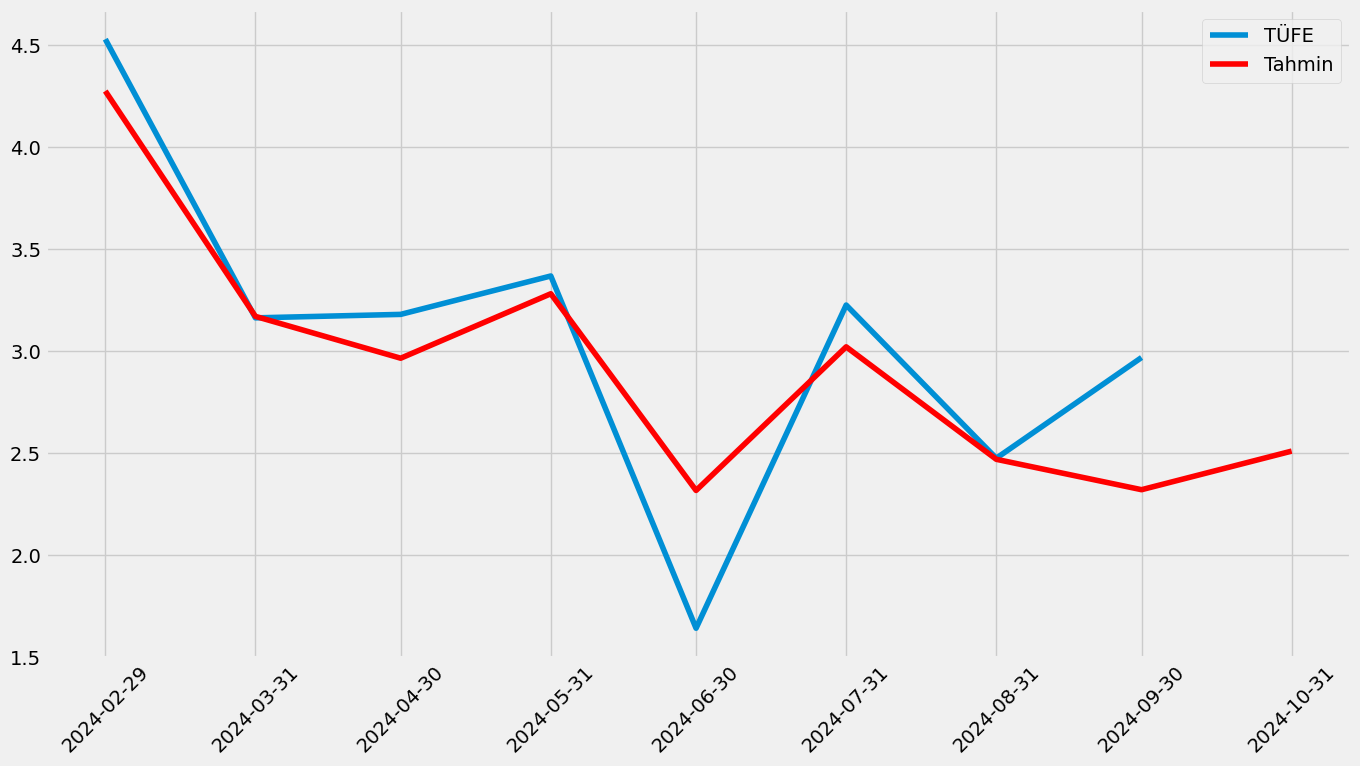

In [261]:
plt.figure(figsize=(15,8))
plt.plot(kısatahminler["TÜFE"].iloc[-9:-1],label="TÜFE")
plt.plot(kısatahminler["Ortalama"].iloc[-9:],label="Tahmin",color="red")
plt.xticks(kısatahminler.index[-9:],rotation=45)
plt.legend()

## Orta Vadeli Tahminler

In [58]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-07-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-07-31,50.000000
2024-08-31,50.337619
2024-09-30,50.719048
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000
2025-01-31,50.000000
2025-02-28,50.000000
2025-03-31,50.000000
2025-04-30,50.000000


In [59]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [60]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2024-06-30,2684.339030
2024-07-31,2738.228154
2024-08-31,2623.214664
2024-09-30,2457.059505


In [61]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,20]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [62]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [63]:
exog=pfaiz["Faiz"].iloc[36:-2]
exog=np.array(exog).reshape(-1,1)

In [64]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [65]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-09-30,8.618426
2024-10-31,8.563926
2024-11-30,8.503014
2024-12-31,8.528139
2025-01-31,8.515437
2025-02-28,8.502925
2025-03-31,8.508086
2025-04-30,8.505477
2025-05-31,8.502907
2025-06-30,8.503967


In [66]:
from prophet import Prophet

In [67]:
import optuna


In [68]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.50,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=usd.index\n    sn["y"]=usd.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],sea

In [69]:
"""study.best_params"""

'study.best_params'

In [70]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=5.828175414699565,changepoint_range=0.900080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

10:13:50 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(19).pct_change()*100).dropna()
usdtahmin

ds
2024-10-31    2.286254
2024-11-30    1.117576
2024-12-31    2.174797
2025-01-31    2.163399
2025-02-28    2.015124
2025-03-31    1.975319
2025-04-30    2.002718
2025-05-31    1.963397
2025-06-30    1.925590
2025-07-31    1.889212
2025-08-31    1.884579
2025-09-30    1.819885
2025-10-31    1.787357
2025-11-30    1.755972
2025-12-31    1.725669
2026-01-31    1.724205
2026-02-28    1.612965
2026-03-31    1.156890
Freq: ME, Name: yhat, dtype: float64

In [72]:
usd_aylık=usd.resample('M').mean().dropna()

In [73]:
usdtahmin1 = []
result = usd_aylık.iloc[-2,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":"2024-09-30"],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,31.986743
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.894495
2024-08-31,33.621248
2024-09-30,34.030467
2024-10-31,34.808489
2024-11-30,35.197501
2024-12-31,35.962975


In [74]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [75]:
"""study.best_params"""

'study.best_params'

In [76]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=0.9,changepoint_range=0.40,seasonality_prior_scale=19.378940289163559,n_changepoints=1000)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing


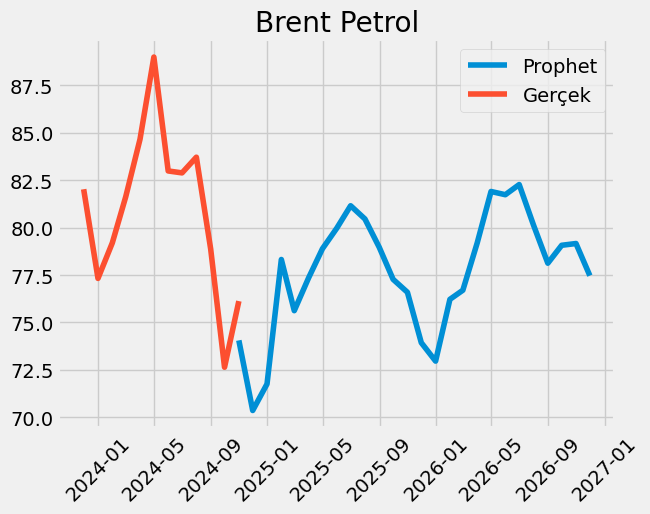

In [77]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [78]:
brenttahmin=pd.read_excel("brent.xlsx")

brenttahmin=brenttahmin.set_index(pd.to_datetime(brenttahmin["Date"]))
brenttahmin=brenttahmin[["Brent"]]
brenttahmin

,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2025-11-30,79.772990
2025-12-31,81.763713
2026-01-31,80.259333


In [79]:
brenttahmin=brenttahmin.loc["2024-07-31":]
brenttahmin

,Brent
Date,
2024-07-31,83.717727
2024-08-31,78.875001
2024-09-30,72.638499
2024-10-31,76.407143
2024-11-30,79.220173
2024-12-31,82.340262
2025-01-31,80.355057
2025-02-28,79.079080
2025-03-31,78.705307


In [80]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

10:13:53 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1] done processing


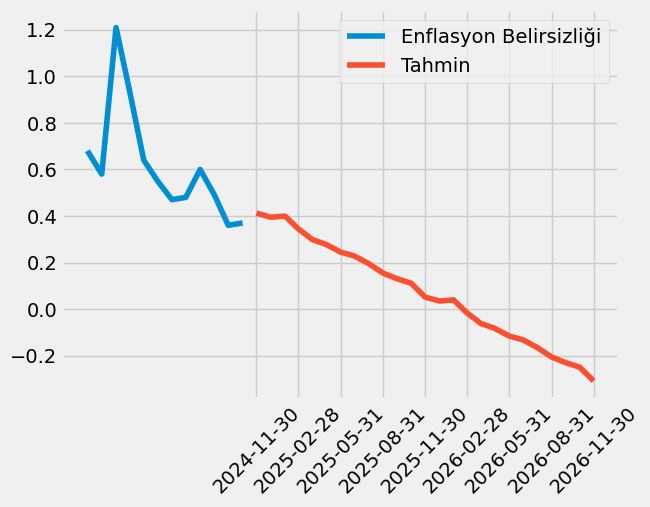

In [81]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=10,changepoint_range=0.82,seasonality_prior_scale=0.003403857042852,n_changepoints=6,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [82]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-10-31,0.370000
2024-11-30,0.412141
2024-12-31,0.394721
2025-01-31,0.399535
2025-02-28,0.345820
2025-03-31,0.298573
2025-04-30,0.277506
2025-05-31,0.244807
2025-06-30,0.228210


In [83]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [84]:
#study.best_params

In [85]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

,Brent
Date,
2024-08-31,-5.784588
2024-09-30,-7.906817
2024-10-31,5.188218
2024-11-30,3.681632
2024-12-31,3.938503
2025-01-31,-2.410977
2025-02-28,-1.587924
2025-03-31,-0.472657
2025-04-30,-2.552809


In [86]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[4:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-08-30",periods=len(motorintahmin),freq="1M"))
motorintahmin=(motorintahmin-1)*100
motorintahmin

,Motorin
2024-08-31,-3.703047
2024-09-30,-6.785910
2024-10-31,7.593088
2024-11-30,4.840354
2024-12-31,6.198954
2025-01-31,-0.299737
2025-02-28,0.395201
2025-03-31,1.493325
2025-04-30,-0.601216
2025-05-31,4.941933


In [87]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [88]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.904897796889,changepoint_range=0.9529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
paraarzitahmin=(predictions["yhat"]).tail(25)
paraarzitahmin

ds
2024-11-30    2.554415
2024-12-31    2.566076
2025-01-31    1.058144
2025-02-28    1.387982
2025-03-31    3.048794
2025-04-30    2.555488
2025-05-31    2.125850
2025-06-30    2.499390
2025-07-31    1.666041
2025-08-31    1.864473
2025-09-30    1.727567
2025-10-31    1.307324
2025-11-30    1.480818
2025-12-31    2.146403
2026-01-31    0.239163
2026-02-28    0.802585
2026-03-31    2.192072
2026-04-30    1.138822
2026-05-31    1.343931
2026-06-30    1.952130
2026-07-31    0.633017
2026-08-31    1.767941
2026-09-30    0.554945
2026-10-31    0.099478
2026-11-30    0.420332
Name: yhat, dtype: float64

In [90]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-11-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-05-30",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-05-31,1.018595
2024-06-30,1.048746
2024-07-31,1.074696
2024-08-31,1.115472
2024-09-30,1.137011
2024-10-31,1.139398
2024-11-30,1.168503
2024-12-31,1.198488


In [91]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [92]:
#study.best_params

In [93]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [94]:
"""study.best_params"""

'study.best_params'

In [95]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.01099759561372614,changepoint_range=0.0589785485153,growth="linear",seasonality_prior_scale=0.04157847860739,n_changepoints=10,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing


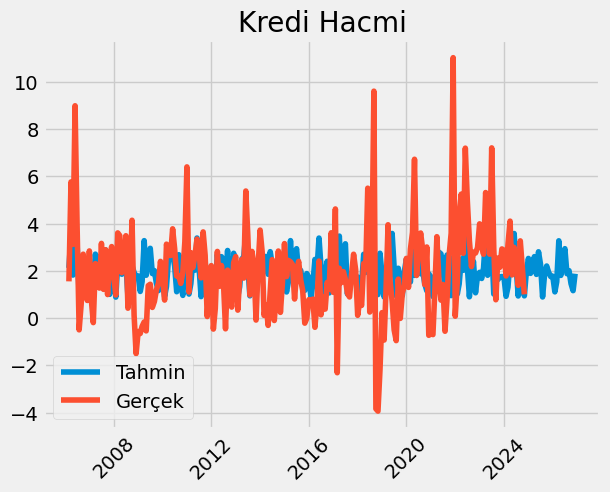

In [96]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [97]:
kreditahmin=(predictions["yhat"]).tail(25)
kreditahmin

ds
2024-11-30    1.970203
2024-12-31    2.530456
2025-01-31    1.895854
2025-02-28    2.309462
2025-03-31    2.607725
2025-04-30    1.853048
2025-05-31    2.812278
2025-06-30    2.283655
2025-07-31    0.898815
2025-08-31    1.888014
2025-09-30    2.209374
2025-10-31    1.933259
2025-11-30    1.763384
2025-12-31    1.776411
2026-01-31    1.113963
2026-02-28    1.542332
2026-03-31    3.276755
2026-04-30    1.811147
2026-05-31    2.602894
2026-06-30    2.943853
2026-07-31    1.884216
2026-08-31    2.012340
2026-09-30    1.461881
2026-10-31    1.165635
2026-11-30    1.881913
Name: yhat, dtype: float64

In [98]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-11-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-07-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-07-31,1.391053
2024-08-31,3.273183
2024-09-30,2.186080
2024-10-31,1.009000
2024-11-30,1.970203
2024-12-31,2.530456
2025-01-31,1.895854
2025-02-28,2.309462
2025-03-31,2.607725
2025-04-30,1.853048


In [99]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [100]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=18,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

10:13:55 - cmdstanpy - INFO - Chain [1] start processing
10:13:55 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
m3tahmin=(predictions["yhat"].tail(18))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-11-30", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-07-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-07-31,3.494408
2024-08-31,4.335055
2024-09-30,2.933112
2024-10-31,0.871700
2024-11-30,2.983047
2024-12-31,2.224156
2025-01-31,1.234901
2025-02-28,1.710515
2025-03-31,3.127213
2025-04-30,2.673740


In [102]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [103]:
#study.best_params

In [104]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [105]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1["M3"].shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.rolling(3).mean()
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].shift(1).rolling(2).mean()
tahmindf["Kredi2"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"].rolling(2).mean()
tahmindf["Motorin2"]=motorintahmin["Motorin"]
tahmindf["İşsizlik"]=issizliktahmin





tahmindf=tahmindf[['USD/TL', 'Motorin','Motorin2', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','Kredi2','İşsizlik']]

tahmindf.columns=["USD/TL","Motorin","Motorin2","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','Kredi2','İşsizlik']
tahmindf=tahmindf.loc["2024-10-30":]
enfbelirsizliktahmin=pd.read_excel("enfbelirsizliktahmin.xlsx")
enfbelirsizliktahmin=enfbelirsizliktahmin.set_index("Unnamed: 0")
enfbelirsizliktahmin=enfbelirsizliktahmin.loc["2024-09-30":]
enfbelirsizliktahmin=enfbelirsizliktahmin.set_index(pd.date_range(start="2024-10-31",freq="M",periods=len(enfbelirsizliktahmin)))

tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin["Series"]


tahmindf["Motorin"].iloc[0]=data["Motorin"].iloc[-1]
tahmindf["ParaArzi"].iloc[0]=data["ParaArzi"].iloc[-1]
tahmindf["M3"].iloc[0]=data["M3"].iloc[-1]
tahmindf["Kredi"].iloc[0]=data["Kredi"].iloc[-1]
tahmindf["Enflasyon Belirsizliği"].iloc[0]=enf_belirsizlik.iloc[-1,0]
tahmindf["Zam"].iloc[-1]=0
tahmindf

,USD/TL,Motorin,Motorin2,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,Kredi2,İşsizlik
2024-10-31,1.903596,-0.975000,7.593088,0.0,0.370000,1.978368,2.713289,2.729631,2.156088,8.563926
2024-11-30,1.538405,6.216721,4.840354,0.0,0.264145,1.565101,0.871700,1.597540,1.721761,8.503014
2024-12-31,1.857530,5.519654,6.198954,0.0,0.328252,1.776830,2.983047,1.489602,1.836553,8.528139
2025-01-31,1.823655,2.949609,-0.299737,25.0,0.525745,2.059545,2.224156,2.250329,2.132171,8.515437
2025-02-28,2.116629,0.047732,0.395201,0.0,0.410114,1.670734,1.234901,2.213155,2.245257,8.502925
2025-03-31,2.049978,0.944263,1.493325,0.0,0.301573,1.831640,1.710515,2.102658,2.271013,8.508086
2025-04-30,1.997639,0.446055,-0.601216,0.0,0.308343,2.330755,3.127213,2.458593,2.256745,8.505477
2025-05-31,1.980397,2.170359,4.941933,0.0,0.287528,2.576711,2.673740,2.230386,2.424350,8.502907
2025-06-30,1.963397,3.502350,2.062768,0.0,0.359421,2.393576,2.551423,2.332663,2.316327,8.503967
2025-07-31,1.925590,1.686173,1.309578,0.0,0.381228,2.097094,2.619444,2.547967,1.998249,8.503431


In [106]:
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi','Zam', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data




,USD/TL,Motorin,M3,Enflasyon Belirsizliği,TÜFEt-1,Kredi,İhracat,İthalat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,Anket,ParaArzi,Zam,TÜFE
0,0.242795,0.045780,-0.281651,-0.549098,0.034119,0.794352,-0.563781,-1.372763,-0.983134,-0.384353,-0.904975,0.368211,-0.720620,-0.660328,-0.233739,-0.285157,-0.663408
1,0.070862,-0.364572,-0.808078,-0.935744,-0.660889,-0.295799,0.288276,-0.647443,-0.983134,0.368824,-0.706734,-0.290773,-0.535181,-0.690277,-0.698037,-0.285157,-0.350960
2,-1.083184,-0.992838,-1.210641,-0.755309,-0.348151,-0.969408,0.866903,1.095417,-0.852387,-0.290004,-0.521403,-0.511213,-0.300831,-0.607917,-1.088316,-0.285157,-0.252684
3,-1.239154,-0.856333,-1.354773,-0.677980,-0.249783,-1.096684,-0.696791,-0.008390,-0.852387,-0.510392,-0.287189,-0.732767,0.134463,-0.705251,-1.306650,-0.285157,-0.678178
4,-1.156200,-0.143470,-0.964894,-0.523321,-0.675672,-0.925349,0.042057,-0.044770,-0.852387,-0.731894,0.147853,-0.939241,-0.156534,-1.012228,-0.955307,-0.285157,-0.716005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,-0.508286,-0.553548,0.508177,-0.110899,0.657421,0.281923,1.836049,0.383371,-1.244627,0.465341,0.828678,-0.095276,0.909285,0.709837,-0.022997,-0.285157,-0.120161
125,-0.499684,0.430809,0.721900,0.198418,-0.117138,0.417688,-1.716687,-1.742767,-1.440747,-0.094554,0.922226,-0.293275,-0.050780,0.897018,0.065615,-0.285157,0.589834
126,-0.250035,0.273298,0.871989,-0.085122,0.593517,-0.067024,1.295787,1.684041,-1.440747,-0.292506,-0.037282,-0.100825,0.292304,0.732298,0.414007,-0.285157,0.253317
127,-0.214392,-0.682495,0.730917,-0.420216,0.256688,0.232213,-0.244411,-0.892983,-1.440747,-0.100639,0.305602,-0.190121,0.546672,0.485219,0.228669,-0.285157,0.474536


In [107]:
"""import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
features=['M3','ParaArzi','Enflasyon Belirsizliği','Kredi','İşsizlik']
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    selected_features = ["USD/TL","Motorin","Zam"]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

'import optuna\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN\nimport keras\nfrom keras.callbacks import EarlyStopping\nfrom keras import regularizers\nfrom keras.layers import LSTM, Dense, Dropout\nfrom keras.regularizers import l2,l1\nfeatures=[\'M3\',\'ParaArzi\',\'Enflasyon Belirsizliği\',\'Kredi\',\'İşsizlik\']\ndef weighted_mse(y_true, y_pred):\n    n = len(y_true)\n    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar\n    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)\n    mse = np.sum(weights * (y_true - y_pred) ** 2) / n\n    return mse\ndef objective(trial):\n    # Define hyperparameters to be optimized\n    selected_features = ["USD/TL","Motorin","Zam"]\n    for feature in features:\n        if trial.suggest_categorical(feature, (True, False)):\n            selected_features.append(feature)\n\n    if len(selected_features) == 0:\n        return float(\'i

In [108]:
features=['Enflasyon Belirsizliği', 'Kredi2', 'USD/TL', 'Motorin', 'Zam','ParaArzi','İşsizlik']

data1=data[features]
data1=pd.concat([data1,tahmindf[features]],axis=0)
data1["TÜFE"]=data["TÜFE"]
data1=data1.fillna(0)
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))






In [109]:
trials=pd.read_excel("futuretrial4.xlsx")
del trials["Unnamed: 0"]
predictions=pd.DataFrame()
for i in range(10):
    trial=trials.iloc[i:i+1]
    selected_features=['Enflasyon Belirsizliği', 'Kredi2', 'USD/TL', 'Motorin', 'Zam','ParaArzi','İşsizlik']






    

    X = scaled_data[selected_features]
    y = scaled_data["TÜFE"]
    
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    
    X = pd.DataFrame(X, columns=selected_features)
    y = pd.DataFrame(y, columns=["TÜFE"])
    
    X_train, X_test = X.iloc[:-27, :], X.iloc[-18:, :]
    y_train, y_test = y[:-27], y[-18:]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    



    units=int(trial["params_units1"].values[0])
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=int(trial["params_batch_size"].values[0])
    
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1])))
    model.add(Dropout(rl))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))

   


    pred=scaler2.inverse_transform(model.predict(np.array(X_test)))
    pred=pd.DataFrame(pred)
    pred.columns=["TÜFE"]
    pred=pred.set_index(pd.date_range(start="2024-10-31",periods=len(tahmindf),freq="1M"))
    pred.iloc[0]=kısatahminler["Ortalama"].iloc[-1]
    predictions=pd.concat([predictions,pred["TÜFE"]],axis=1)

Epoch 1/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.7559 - mean_squared_error: 0.7559WARNING:tensorflow:5 out of the last 18 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x000001E95E2C5B40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.6741 - mean_squared_error: 0.6741 - val_loss: 0.0812 - val_mean_squared_error: 0.0812
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss

In [110]:
def create_tüfe(data):
    tüfetahmin = []
    result = enf["TÜFE"].iloc[-1]
    pred=np.array(data.values).reshape(1,-1).ravel()
    for i in range(len(pred)):
        result *= (1 + (pred[i] / 100))
        tüfetahmin.append(result)
    tüfetahmin[0]=enf["TÜFE"].iloc[-1]*(1+(data[0]/100))

    tüfetahmin = np.array(tüfetahmin).reshape(-1, 1)
    tüfetahmin = pd.DataFrame(tüfetahmin)
    tüfetahmin = tüfetahmin.set_index(pd.date_range(start="2024-10-30", periods=len(tüfetahmin), freq="1M"))
    return tüfetahmin


In [111]:
tüfetahmin_dict={}
for i in range(len(predictions.columns)):
    # Dinamik olarak bir sözlük içinde tahminleri saklıyoruz.
    tüfetahmin_dict[f"tüfetahmin_{i}"] = create_tüfe(predictions.iloc[:, i])
    # Kolon adını güncelleme
    tüfetahmin_dict[f"tüfetahmin_{i}"].columns = [f"NN_{i}"]





In [112]:
tüfetahmin=pd.concat(tüfetahmin_dict.values(), axis=1)


In [113]:
std=tüfetahmin.std(axis=1)

In [114]:
predictions.columns=tüfetahmin.columns

In [115]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))


std=tüfetahmin.std(axis=1)

dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.mean(axis=1)],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=["Ortalama"]


dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.max(axis=1)+3*std],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["Max"]

dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.min(axis=1)-2*std],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=["Min"]
dfas3["Min"].loc["2024-10-31":]-=(std.loc["2024-10-31":])

dfas0=pd.DataFrame()
for i in range(tüfetahmin.shape[1]):
    dfas00=pd.DataFrame()
    dfas00=pd.concat([df["CPI"],tüfetahmin.iloc[:,i]],axis=0)
    dfas00=pd.DataFrame(dfas00)
    dfas00.columns=[f"NN_{i}"]
    dfas0=pd.concat([dfas0,dfas00],axis=1)



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas0],axis=1)
dfas=dfas.dropna(axis=0)
dfas=dfas.drop("NN_1",axis=1)
dfas["Ortalama"]=dfas.mean(axis=1)
dfas["Max"]=dfas2["Max"]
dfas["Min"]=dfas3["Min"]
dfas=dfas.pct_change(periods=12)*100
df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)







In [116]:
dfas["Ortalama"].to_excel("tüfetahmin.xlsx",index=True)

In [117]:
predictions=predictions[dfas.columns[1:-2]]
predictions["Ortalama"]=predictions.mean(axis=1)

In [118]:
std=predictions.iloc[:,:-1].std(axis=1)

In [119]:
sonu12024=str(dfas["Ortalama"].loc["2024-12-31"])[:5]
min2024=str(dfas["Min"].loc["2024-12-31"])[:5]
max2024=str(dfas["Max"].loc["2024-12-31"])[:5]

In [120]:
min2025=str(dfas["Min"].loc["2025-12-31"])[:5]
max2025=str(dfas["Max"].loc["2025-12-31"])[:5]

In [121]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-10-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-10-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-10-31,44.11


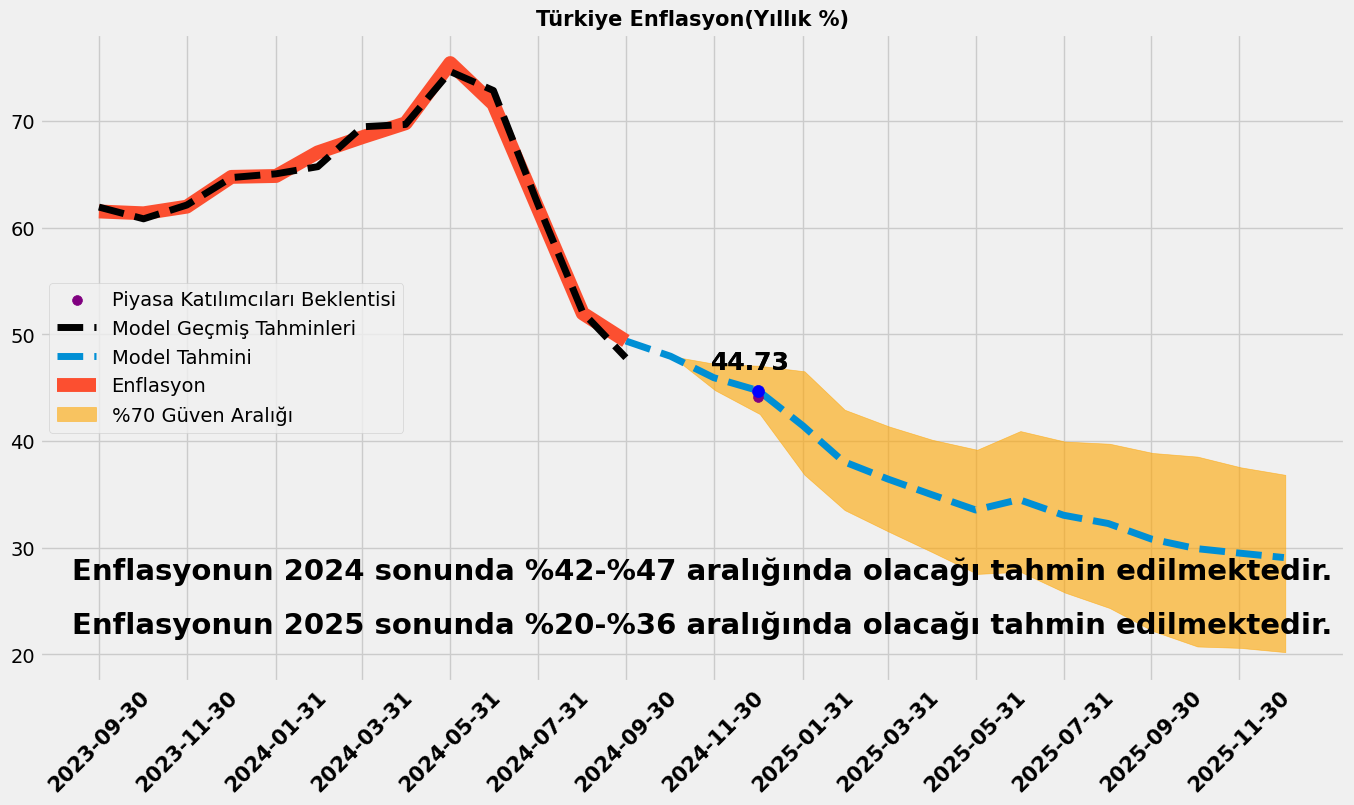

In [122]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50,label="Piyasa Katılımcıları Beklentisi")
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65,72.87,62.17,52.07,47.82]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",periods=len(geçmiş),freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.scatter(x=dfas.loc["2024-12-31":].index[0],y=dfas["Ortalama"].loc["2024-12-31"],color='blue',zorder=4,s=75)
plt.plot(dfas["Ortalama"].loc["2024-09-30":"2025-12-31"],'--',label="Model Tahmini",linewidth=5)
plt.plot(dfas["Ortalama"].loc["2023-09-30":"2024-09-30"],label="Enflasyon",linewidth=10)
plt.fill_between(dfas.loc["2024-10-31":"2026-01-31"].index.strftime("%Y-%m"), dfas["Max"].loc["2024-10-31":"2026-01-31"].shift(1), dfas["Min"].loc["2024-10-31":"2026-01-31"].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
annotation_date = mdates.datestr2num('2024-11')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+2, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 27, f"Enflasyonun 2024 sonunda %{min2024[:2]}-%{max2024[:2]} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='center',fontweight='bold')

annotation_date = mdates.datestr2num('2024-11')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+2, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2025 sonunda %{min2025[:2]}-%{max2025[:2]} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='center',fontweight='bold')

plt.xticks(dfas.loc["2023-09-30":"2025-12-31"].index[::2],rotation=45,fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png', bbox_inches='tight')
plt.savefig("./forecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')
plt.show()

In [123]:
predictions.columns=["NN1","NN2","NN3","NN4","NN5","NN6","NN7","NN8","NN9","Ortalama"]

In [124]:
modelaylık=kısatahminler.iloc[-1:,1:-2]
modelaylık["Ortalama"]=kısatahminler["Ortalama"].iloc[-1]
modelaylık["Ensemble"]=kısatahminler["Ensemble"].iloc[-1]
modelaylık

,NN1,NN2,NN3,NN4,Ortalama,Ensemble
2024-10-31,2.312337,2.543516,2.356109,2.562825,2.443697,2.412343


In [125]:

aylık=pd.concat([data["TÜFE"][:-1],predictions["Ortalama"]],axis=0)
aylık

2014-02-28    0.428192
2014-03-31    1.125608
2014-04-30    1.344970
2014-05-31    0.395224
2014-06-30    0.310791
                ...   
2025-11-30    1.541913
2025-12-31    1.738523
2026-01-31    3.188553
2026-02-28    1.442985
2026-03-31    1.442230
Length: 146, dtype: float64

In [126]:
aylık.to_csv("C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv")

In [127]:
modelaylık.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [128]:
yıllıktahmin1=dfas


yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05'),
  Text(9, 0, '2024-06'),
  Text(10, 0, '2024-07'),
  Text(11, 0, '2024-08'),
  Text(12, 0, '2024-09')])

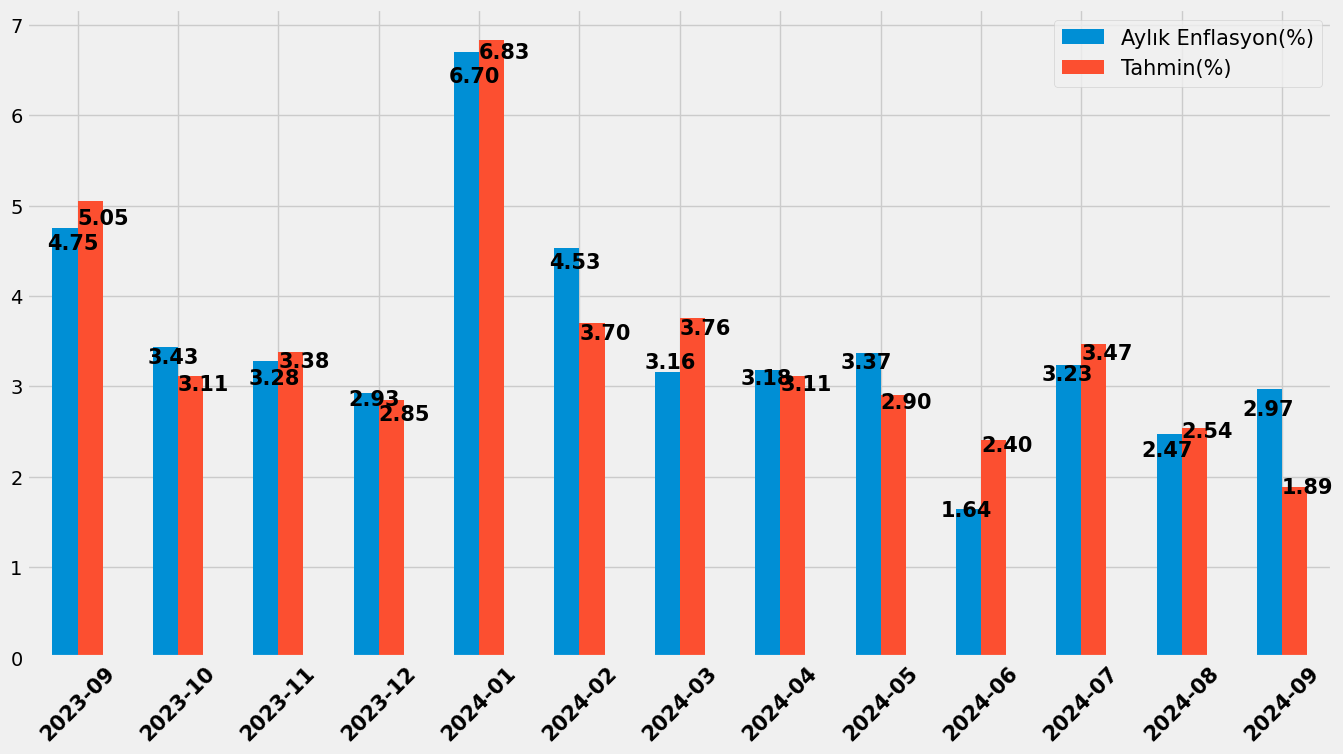

In [129]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37,1.64,3.23,2.47,2.97],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90,2.40,3.47,2.54,1.89]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=13,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(15,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.92),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.92),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.97),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("1.64",xy=(8.6,gecmis.iloc[9,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.40",xy=(9,gecmis.iloc[9,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.23",xy=(9.6,gecmis.iloc[10,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.47",xy=(10,gecmis.iloc[10,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.47",xy=(10.6,gecmis.iloc[11,0]*0.90),fontweight="bold",fontsize=15)
plt.annotate("2.54",xy=(11,gecmis.iloc[11,1]*0.96),fontweight="bold",fontsize=15)
plt.annotate("2.97",xy=(11.6,gecmis.iloc[12,0]*0.90),fontweight="bold",fontsize=15)
plt.annotate("1.89",xy=(12,gecmis.iloc[12,1]*0.96),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=45,fontweight="bold",fontsize=15,color="black")

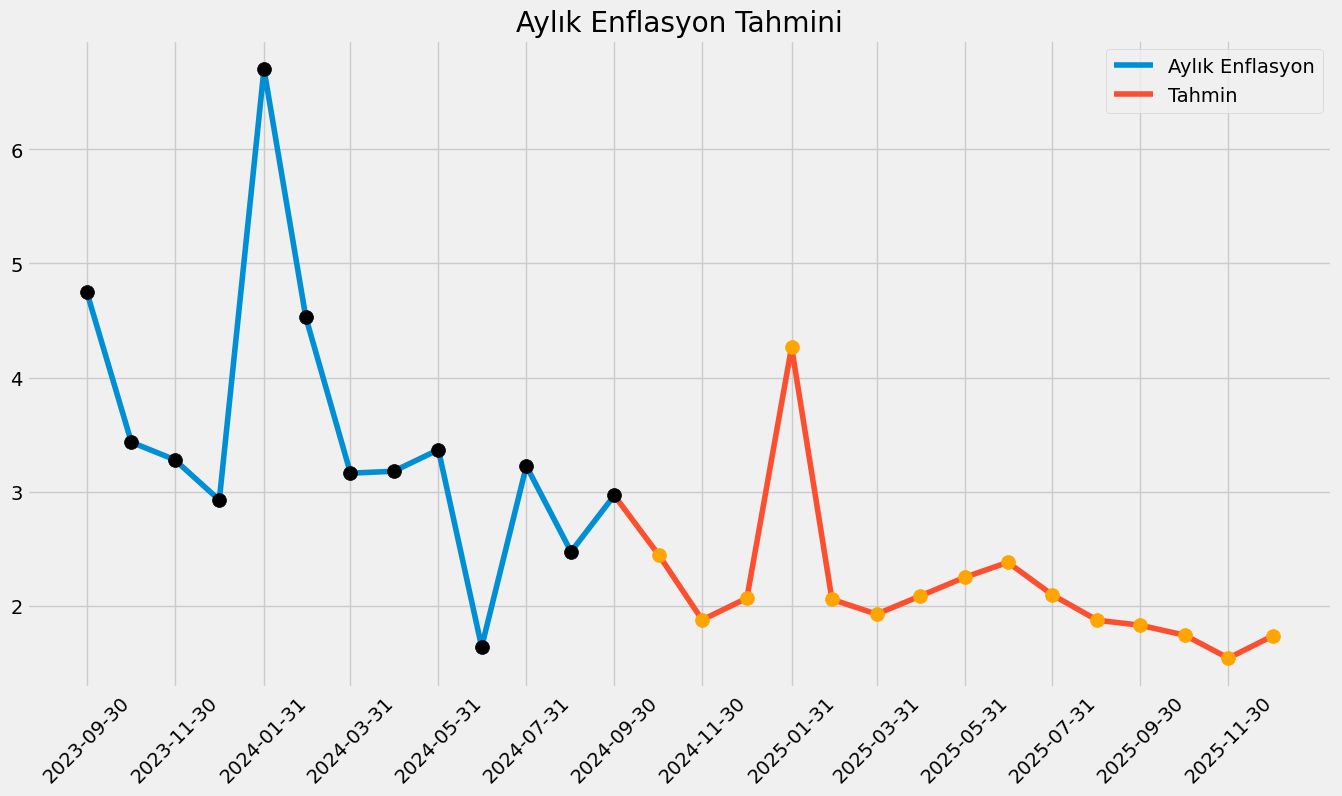

In [130]:
plt.figure(figsize=(15,8))
plt.title("Aylık Enflasyon Tahmini")
plt.plot(aylık.loc["2023-09-30":"2024-09-30"],label="Aylık Enflasyon")
plt.plot(aylık.loc["2024-09-30":"2025-12-31"],label="Tahmin")
plt.scatter(x=aylık.loc["2023-09-30":"2024-09-30"].index,y=aylık.loc["2023-09-30":"2024-09-30"],color="black",s=100,zorder=3)
plt.scatter(x=aylık.loc["2024-10-30":"2025-12-31"].index,y=aylık.loc["2024-10-30":"2025-12-31"],color="orange",s=100,zorder=3)
plt.xticks(aylık.loc["2023-09-30":].index[:-3:2],rotation=45)
plt.legend()

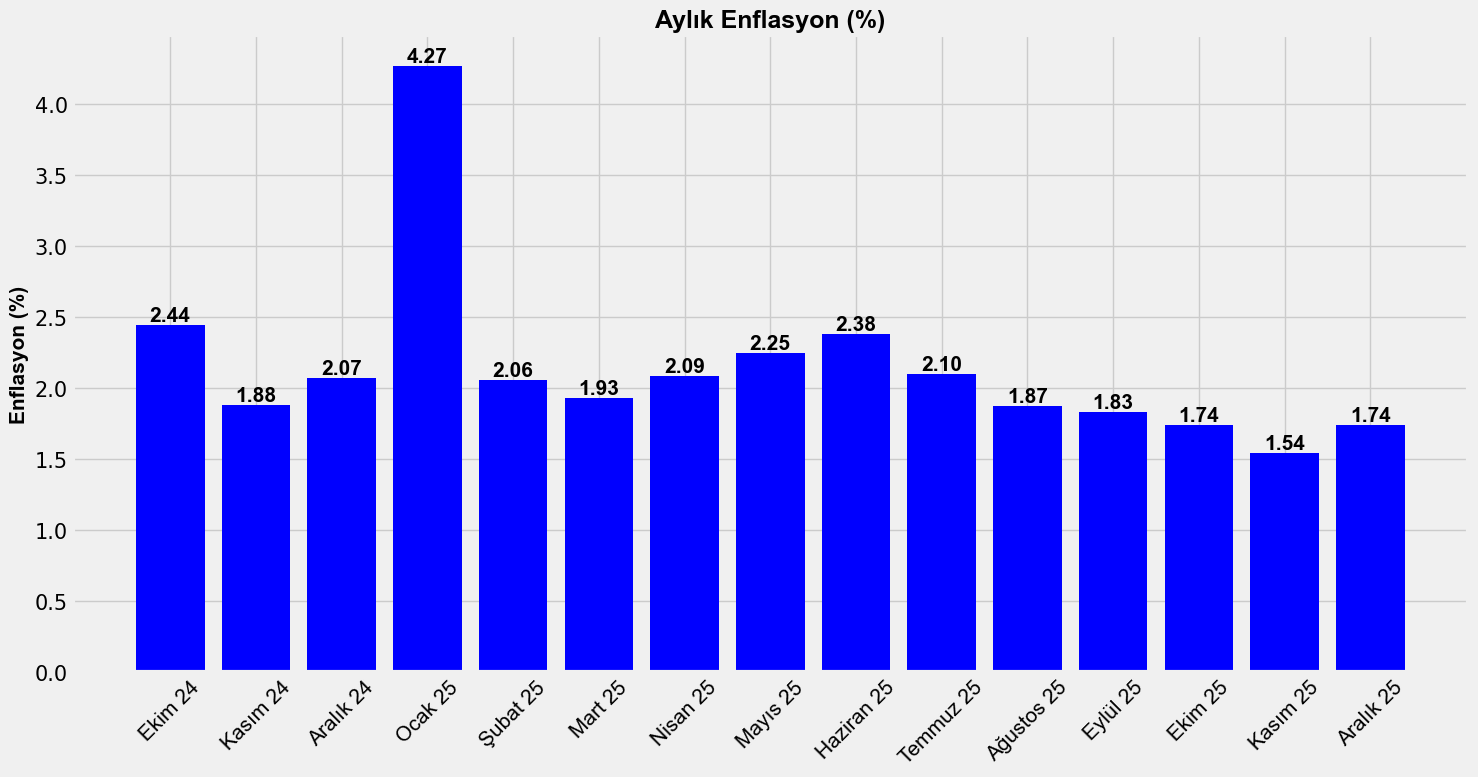

In [131]:

turkish_months = [ "Ekim 24", "Kasım 24", "Aralık 24", "Ocak 25", "Şubat 25",
    "Mart 25", "Nisan 25", "Mayıs 25", "Haziran 25", "Temmuz 25", "Ağustos 25",
    "Eylül 25", "Ekim 25", "Kasım 25", "Aralık 25"
]

# Çubuk grafiği oluşturma
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(
    turkish_months,
    aylık.loc["2024-10-30":"2025-12-31"],
    color='blue'
)

# Barların üstüne değerleri yazma
for bar, value in zip(bars, aylık.loc["2024-10-30":"2025-12-31"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X pozisyonu (barın ortası)
        bar.get_height(),  # Y pozisyonu (barın yüksekliği)
        f'{value:.2f}',  # Yazılacak metin (2 ondalık basamak)
        ha='center',  # Metni ortala
        va='bottom',  # Barın üst kısmına yerleştir
        fontsize=15,
        fontweight='bold',
        color='black',
        family="Arial"
    )

# X ekseni ayarları
ax.set_xticks(np.arange(len(turkish_months)))
ax.set_xticklabels(turkish_months, rotation=45, fontsize=15, color="black", fontfamily="Arial")

# Y ekseni ayarları
ax.set_ylabel("Enflasyon (%)", fontsize=15, fontweight='bold', color="black", fontfamily="Arial")
ax.tick_params(axis='y', labelsize=15, labelcolor='black')

# Başlık
ax.set_title("Aylık Enflasyon (%)", fontsize=18, fontweight='bold', color="black", fontfamily="Arial")

# Grafik düzenlemesi
plt.tight_layout()
plt.savefig('forecast.png', bbox_inches='tight')
plt.savefig("./monthlyforecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')
plt.show()

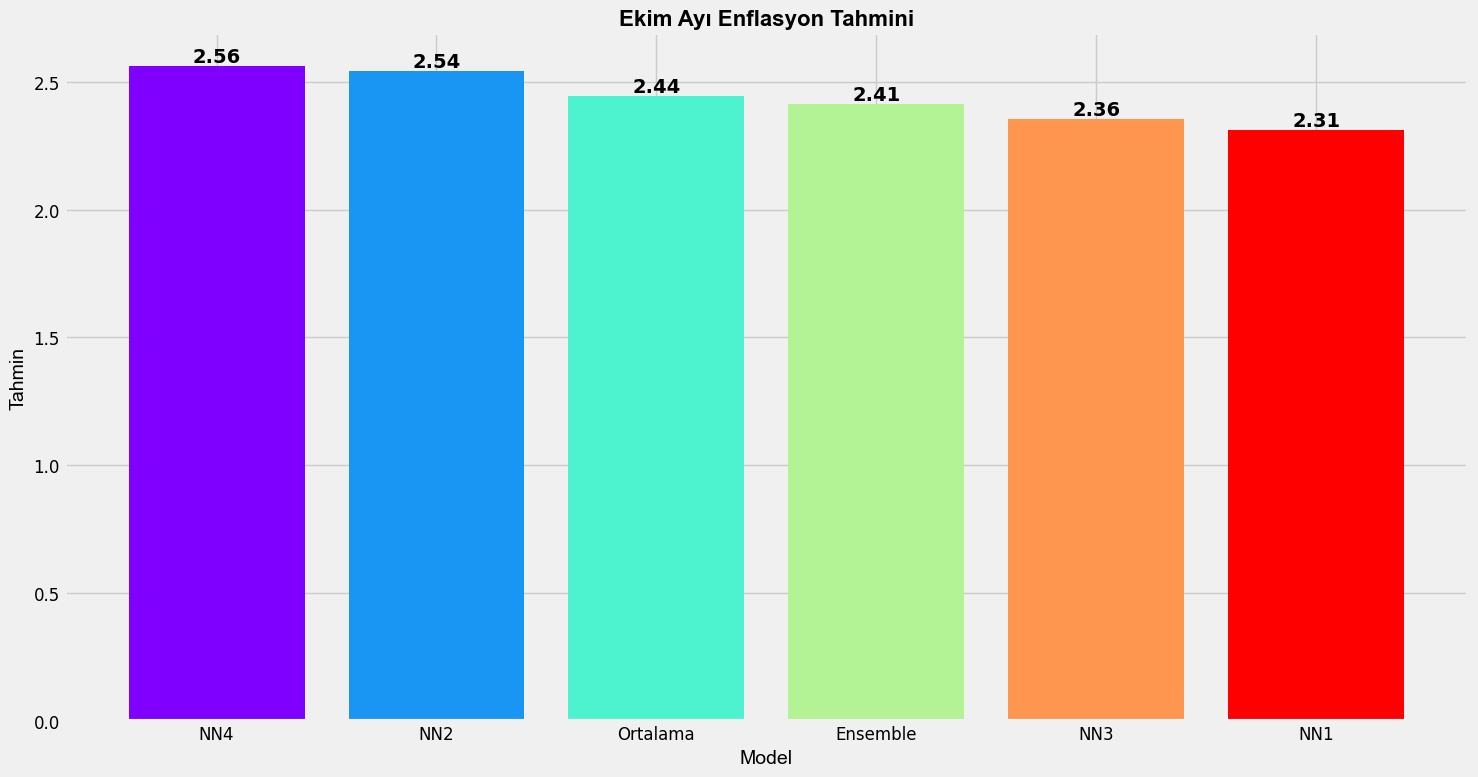

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import Normalize

sorted_index = modelaylık.iloc[0, :].sort_values(ascending=False).index
sorted_modelaylık = modelaylık[sorted_index]

# Renk haritasını oluştur (Viridis yerine Rainbow kullanılacak)
colors = cm.rainbow(np.linspace(0, 1, len(sorted_modelaylık.columns)))

# Çubuk grafiği oluşturma
fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar(
    sorted_modelaylık.columns,  # X ekseni
    sorted_modelaylık.iloc[0, :].values,  # Y ekseni
    color=colors  # Renk haritası
)

# Çubukların üzerine metin yerleştirme
for bar, value in zip(bars, sorted_modelaylık.iloc[0, :].values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X pozisyonu
        bar.get_height(),  # Y pozisyonu
        f'{value:.2f}',  # Yazılacak metin
        ha='center',  # Ortala
        va='bottom',  # Çubuğun üstüne yerleştir
        fontsize=14,
        color="black",
        fontweight="bold"
    )

# Başlık ve etiketler
ax.set_title("Ekim Ayı Enflasyon Tahmini", fontsize=16, fontweight='bold', fontfamily="Arial", color="black")
ax.set_ylabel("Tahmin", fontsize=14, fontfamily="Arial", color="black")
ax.set_xlabel("Model", fontsize=14, fontfamily="Arial", color="black")

# Eksendeki yazı tiplerini ayarlama
ax.tick_params(axis='x', labelsize=12, colors="black", labelrotation=0)
ax.tick_params(axis='y', labelsize=12, colors="black")

# Grafik düzenlemesi
plt.tight_layout()
plt.savefig("./monthlymodelforecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')


plt.show()

In [133]:
import pandas as pd
from datetime import datetime

# CSV dosyasını oku
csv_file = "C:/Users/Bora/Documents/GitHub/streamlit-inflation/cariay.csv"
df = pd.read_csv(csv_file, index_col=0)

# Bugünün tarihini "dd-mm-yyyy" formatında al
today_date = datetime.today().strftime("%Y-%m-%d")

# Yeni tahmin değeri
new_tahmin = kısatahminler["Ortalama"].iloc[-1]

try:
    df.loc[today_date] = new_tahmin
except:
    pass
df=df.loc["2024-10-04":]
df.to_csv(csv_file)

print(f"{today_date} tarihli tahmin başarıyla eklendi.")


2024-10-22 tarihli tahmin başarıyla eklendi.


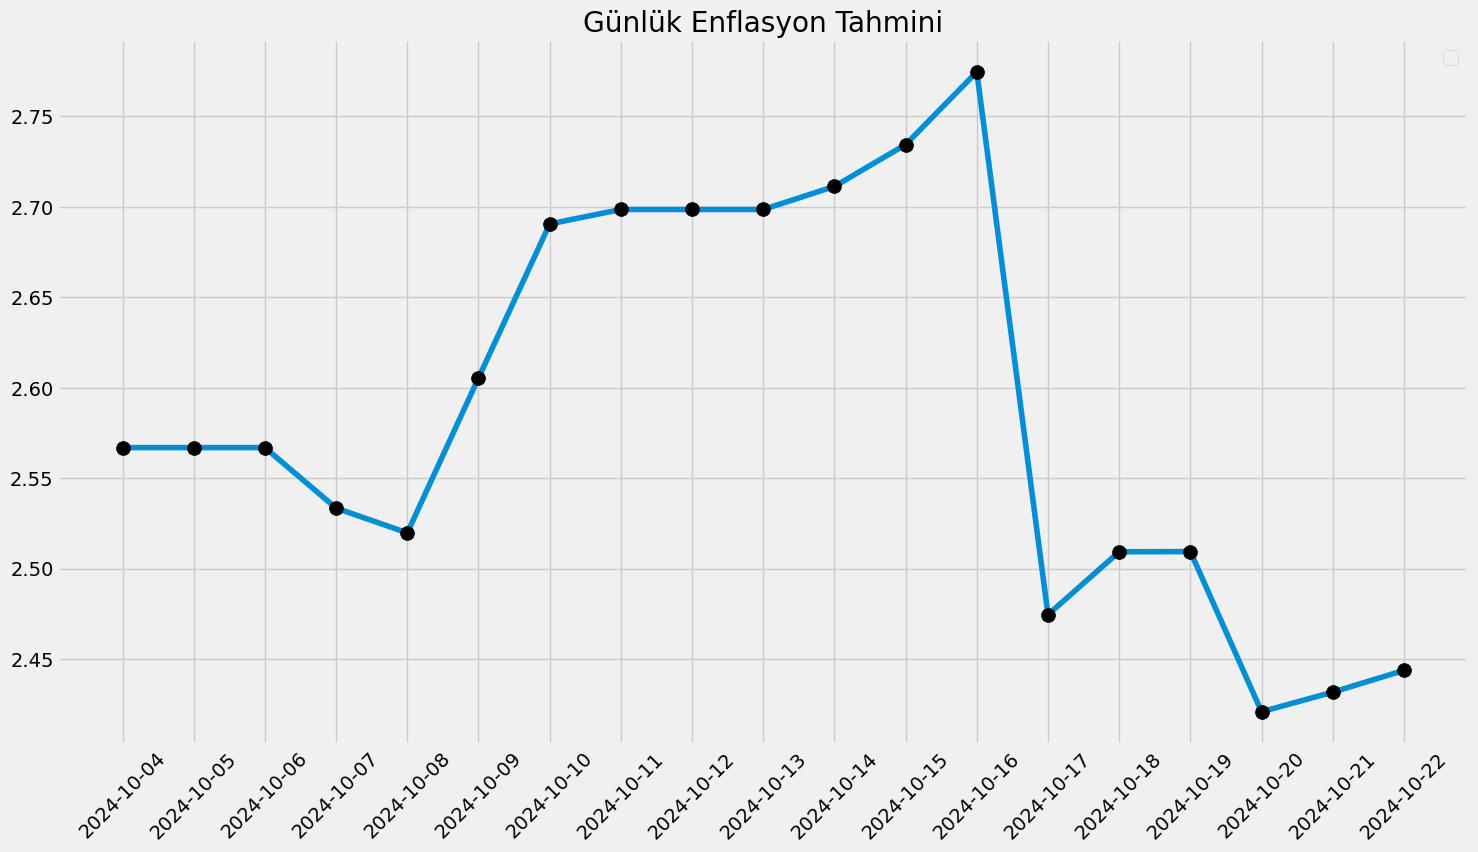

In [134]:
import matplotlib.pyplot as plt
from datetime import date
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Günlük Enflasyon Tahmini")
plt.plot(df)
plt.scatter(x=df.index,y=df["Tahmin"],color="black",s=100,zorder=3)
plt.legend()
plt.tight_layout()
plt.xticks(df.index,rotation=45)
plt.savefig("./dailyforecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')

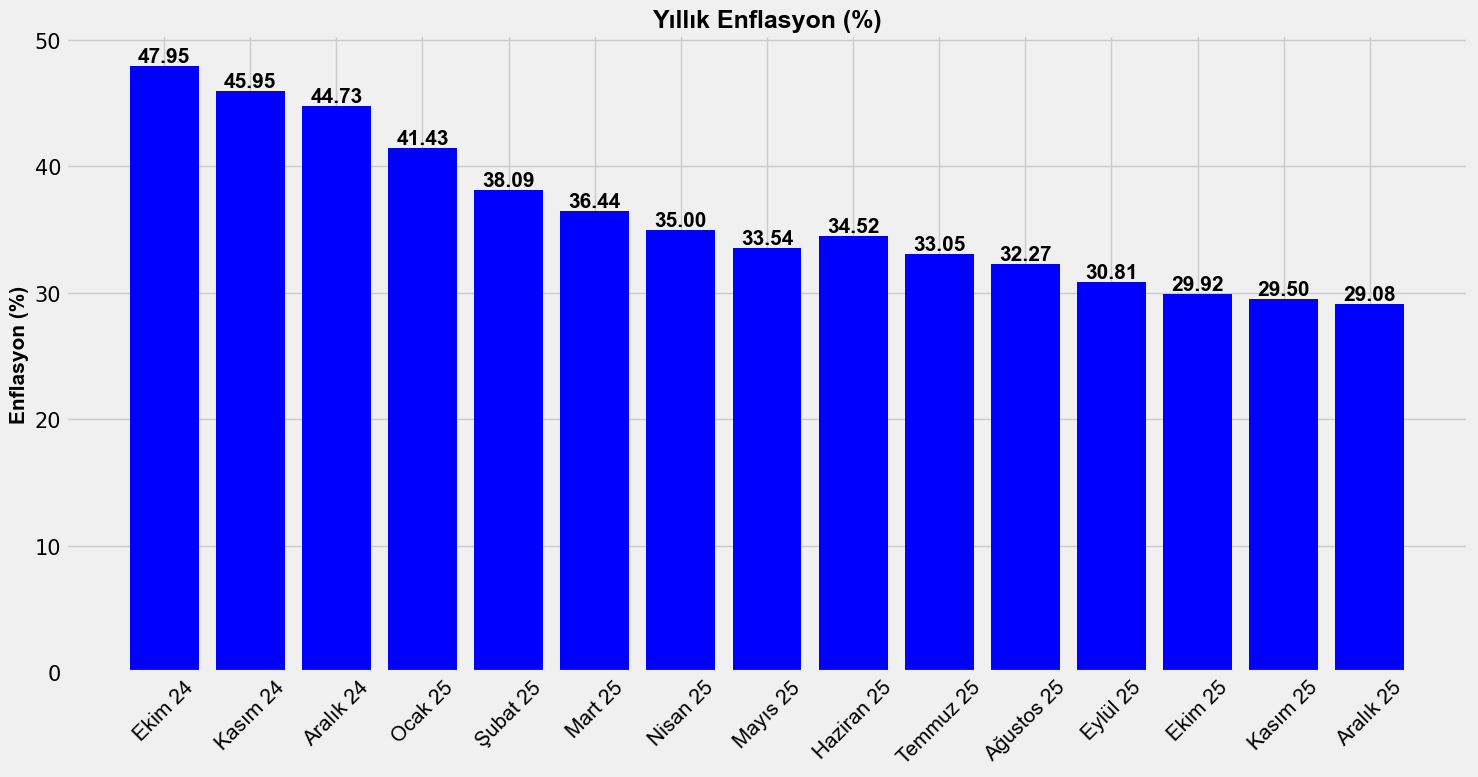

In [135]:

turkish_months = ["Ekim 24", "Kasım 24", "Aralık 24", "Ocak 25", "Şubat 25",
    "Mart 25", "Nisan 25", "Mayıs 25", "Haziran 25", "Temmuz 25", "Ağustos 25",
    "Eylül 25", "Ekim 25", "Kasım 25", "Aralık 25"
]

# Çubuk grafiği oluşturma
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(
    turkish_months,
    yıllıktahmin1["Ortalama"].loc["2024-10-31":"2025-12-31"],
    color='blue'
)

# Barların üstüne değerleri yazma
for bar, value in zip(bars, yıllıktahmin1["Ortalama"].loc["2024-10-31":"2025-12-31"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X pozisyonu (barın ortası)
        bar.get_height(),  # Y pozisyonu (barın yüksekliği)
        f'{value:.2f}',  # Yazılacak metin (2 ondalık basamak)
        ha='center',  # Metni ortala
        va='bottom',  # Barın üst kısmına yerleştir
        fontsize=15,
        fontweight='bold',
        color='black',
        family="Arial"
    )

# X ekseni ayarları
ax.set_xticks(np.arange(len(turkish_months)))
ax.set_xticklabels(turkish_months, rotation=45, fontsize=15, color="black", fontfamily="Arial")

# Y ekseni ayarları
ax.set_ylabel("Enflasyon (%)", fontsize=15, fontweight='bold', color="black", fontfamily="Arial")
ax.tick_params(axis='y', labelsize=15, labelcolor='black')

# Başlık
ax.set_title("Yıllık Enflasyon (%)", fontsize=18, fontweight='bold', color="black", fontfamily="Arial")

# Grafik düzenlemesi
plt.tight_layout()
plt.savefig('forecast.png', bbox_inches='tight')
plt.savefig("./yearlyforecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')
plt.show()